In [3]:
import pandas as pd 
import os
import glob

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from itertools import combinations # 用於生成站點對的組合


# 第三方套件
from rapidfuzz import process, fuzz
from sklearn.neighbors import BallTree #for fast nearest neighbor search
from sklearn.metrics.pairwise import haversine_distances #for distance calculation

In [4]:
%matplotlib inline

## Ask 
- Problem : 行銷主管希望找出如何能讓騎「自行車Casual User」轉換成「Member User」，指派我找出兩者間的行為數據差異。
- Objective : 找出Casual User and Member User之行為差異
- Expected Value : 透過用戶使用腳踏車行為差異，提出洞察分析

### 1-1 建立csv file list，以便後續讀取
數據來源：https://divvy-tripdata.s3.amazonaws.com/index.html

In [5]:
data_directory = os.getcwd()
print(f'資料夾路徑:{data_directory}')

資料夾路徑:c:\Users\User\Dropbox\0_Coding\0_github_repo\my_analysis_projects\exploratory_and_descriptive\1_identifying the difference of various membership riding behaviors


In [6]:
# --- 2. 尋找檔案 ---
# 使用 '*' 作為萬用字元來匹配年份和月份
file_pattern = 'Dataset/*-divvy-tripdata.csv'

#獲取相關檔案名
full_path_pattern = os.path.join(data_directory, file_pattern)
csv_files = glob.glob(full_path_pattern)

csv_files.sort()

if not csv_files:
    print(f"錯誤：在 '{data_directory}' 中找不到符合 '{file_pattern}' 模式的 CSV 檔案。")
    print("請檢查 'data_directory' 路徑和 'file_pattern' 是否正確。")
    exit() # 如果找不到檔案就停止

print(f"找到 {len(csv_files)} 個 CSV 檔案：")
for f in csv_files[:5]: # 只顯示前5個檔名範例
    print(f" - {os.path.basename(f)}")
if len(csv_files) > 5:
    print("   ...")

找到 12 個 CSV 檔案：
 - 202403-divvy-tripdata.csv
 - 202404-divvy-tripdata.csv
 - 202405-divvy-tripdata.csv
 - 202406-divvy-tripdata.csv
 - 202407-divvy-tripdata.csv
   ...


### 1-2 檢查欄位一致性，以便後續檢驗

In [7]:
# 檢查欄位一致性
try:
    # 讀取第一個檔案的欄位名稱作為基準
    base_columns = pd.read_csv(csv_files[0], nrows=0).columns.tolist()
    print(f"基準欄位 (來自 {os.path.basename(csv_files[0])}):\n{base_columns}")
except Exception as e:
    print(f"讀取第一個檔案 '{os.path.basename(csv_files[0])}' 的欄位時發生錯誤: {e}")
    exit()

all_columns_match = True
for file_path in csv_files[1:]: # 從第二個檔案開始檢查
    try:
        current_columns = pd.read_csv(file_path, nrows=0).columns.tolist()
        if current_columns != base_columns:
            print(f"\n!!! 欄位不匹配 !!!")
            print(f"檔案: {os.path.basename(file_path)}")
            print(f"預期欄位: {base_columns}")
            print(f"實際欄位: {current_columns}")
            all_columns_match = False
            # 決定是否停止，這裡選擇停止以策安全
            print("\n偵測到欄位不一致，已停止合併。請先處理欄位差異。")
            exit()
    except Exception as e:
        print(f"讀取檔案 '{os.path.basename(file_path)}' 的欄位時發生錯誤: {e}")
        all_columns_match = False
        print("\n讀取欄位時發生錯誤，已停止合併。")
        exit()

if all_columns_match:
    print("\n所有檔案的欄位名稱和順序一致。可以進行合併。")


基準欄位 (來自 202403-divvy-tripdata.csv):
['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']

所有檔案的欄位名稱和順序一致。可以進行合併。


### 1-3 載入12個csv數據，存取於list

因為是練習用，這裡我加入隨機數據抽樣，避免整體資料量過大。

In [ ]:
all_data_list = []
dtypes_spec = {
    'ride_id': str,
    'rideable_type': str,
    'start_station_name': str,
    'start_station_id': str, # 雖然看起來像數字，但設為str更安全
    'end_station_name': str,
    'end_station_id': str,   # 雖然看起來像數字，但設為str更安全
    'start_lat': float,
    'start_lng': float,
    'end_lat': float,
    'end_lng': float,
    'member_casual': str
}

# 指定需要解析為日期的欄位
date_columns = ['started_at', 'ended_at']

# 設定抽樣比例
sample_fraction = 0.05

for file_path in csv_files:
    print(f"正在讀取: {os.path.basename(file_path)} ...")
    try:
        # 先計算檔案的總行數
        total_rows = sum(1 for _ in open(file_path)) - 1  # 減去標題行
        
        # 計算要抽樣的行數
        n_samples = int(total_rows * sample_fraction)
        
        # 使用 skiprows 隨機抽樣
        skip_idx = sorted(random.sample(range(1, total_rows + 1), total_rows - n_samples))
        
        df_month = pd.read_csv(
            file_path,
            dtype=dtypes_spec,
            parse_dates=date_columns,
            skiprows=skip_idx
        )
        
        all_data_list.append(df_month)
        print(f"  > 讀取完成，從 {total_rows:,} 筆記錄中抽樣 {len(df_month):,} 筆 (約 {sample_fraction*100}%)。")
    except Exception as e:
        print(f"讀取檔案 '{os.path.basename(file_path)}' 時發生錯誤: {e}")
        print("已停止合併。")
        exit()


# -----------------------------------以下為無抽樣讀取所有資料程式碼---------------------------

#all_data_list = []
# dtypes_spec = {
#     'ride_id': str,
#     'rideable_type': str,
#     'start_station_name': str,
#     'start_station_id': str, # 雖然看起來像數字，但設為str更安全
#     'end_station_name': str,
#     'end_station_id': str,   # 雖然看起來像數字，但設為str更安全
#     'start_lat': float,
#     'start_lng': float,
#     'end_lat': float,
#     'end_lng': float,
#     'member_casual': str
# }

# # 指定需要解析為日期的欄位
# date_columns = ['started_at', 'ended_at']

# for file_path in csv_files:
#     print(f"正在讀取: {os.path.basename(file_path)} ...")
#     try:
#         df_month = pd.read_csv(
#             file_path,
#             dtype=dtypes_spec,
#             parse_dates=date_columns
#             # 如果你的 Pandas 版本較新，可以考慮用 on_bad_lines='warn' or 'skip'
#             # 來處理可能的壞行，而不是讓整個讀取失敗
#             # on_bad_lines='warn' # 需要 Pandas 1.3.0+
#         )
#         all_data_list.append(df_month)
#         print(f"  > 讀取完成，共 {len(df_month):,} 筆記錄。")
#     except Exception as e:
#         print(f"讀取檔案 '{os.path.basename(file_path)}' 時發生錯誤: {e}")
#         print("已停止合併。")
#         exit()

正在讀取: 202403-divvy-tripdata.csv ...
  > 讀取完成，從 301,687 筆記錄中抽樣 15,084 筆 (約 5.0%)。
正在讀取: 202404-divvy-tripdata.csv ...
  > 讀取完成，從 415,025 筆記錄中抽樣 20,751 筆 (約 5.0%)。
正在讀取: 202405-divvy-tripdata.csv ...
  > 讀取完成，從 609,493 筆記錄中抽樣 30,474 筆 (約 5.0%)。
正在讀取: 202406-divvy-tripdata.csv ...
  > 讀取完成，從 710,721 筆記錄中抽樣 35,536 筆 (約 5.0%)。
正在讀取: 202407-divvy-tripdata.csv ...
  > 讀取完成，從 748,962 筆記錄中抽樣 37,448 筆 (約 5.0%)。
正在讀取: 202408-divvy-tripdata.csv ...
  > 讀取完成，從 755,639 筆記錄中抽樣 37,781 筆 (約 5.0%)。
正在讀取: 202409-divvy-tripdata.csv ...
  > 讀取完成，從 821,276 筆記錄中抽樣 41,063 筆 (約 5.0%)。
正在讀取: 202410-divvy-tripdata.csv ...
  > 讀取完成，從 616,281 筆記錄中抽樣 30,814 筆 (約 5.0%)。
正在讀取: 202411-divvy-tripdata.csv ...
  > 讀取完成，從 335,075 筆記錄中抽樣 16,753 筆 (約 5.0%)。
正在讀取: 202412-divvy-tripdata.csv ...
  > 讀取完成，從 178,372 筆記錄中抽樣 8,918 筆 (約 5.0%)。
正在讀取: 202501-divvy-tripdata.csv ...
  > 讀取完成，從 138,689 筆記錄中抽樣 6,934 筆 (約 5.0%)。
正在讀取: 202502-divvy-tripdata.csv ...
  > 讀取完成，從 151,880 筆記錄中抽樣 7,594 筆 (約 5.0%)。


### 1-4 整併數據 (12個csv file)
- 觀察點：是否所有數據欄位階相同

In [9]:
# 檢查是否成功讀取了任何數據
if not all_data_list:
    print("\n錯誤：沒有成功讀取任何數據，無法進行合併。")
    exit()

print("\n正在合併所有月份的數據...")
# 使用 concat 合併所有 DataFrame
combined_df = pd.concat(all_data_list, ignore_index=True)
print("數據合併完成！")

# --- 5. 顯示結果 ---
print("\n--- 合併結果預覽 ---")
print(f"合併後的總記錄數: {len(combined_df):,}")

print("\n合併後 DataFrame 的資訊 (dtypes, non-null counts):")
# .info() 會顯示欄位名稱、非空值數量、數據類型和記憶體使用情況
combined_df.info()

print("\n合併後 DataFrame 的前 5 筆記錄:")
combined_df.head()


正在合併所有月份的數據...
數據合併完成！

--- 合併結果預覽 ---
合併後的總記錄數: 289,150

合併後 DataFrame 的資訊 (dtypes, non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289150 entries, 0 to 289149
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             289150 non-null  object        
 1   rideable_type       289150 non-null  object        
 2   started_at          289150 non-null  datetime64[ns]
 3   ended_at            289150 non-null  datetime64[ns]
 4   start_station_name  235251 non-null  object        
 5   start_station_id    235251 non-null  object        
 6   end_station_name    233686 non-null  object        
 7   end_station_id      233686 non-null  object        
 8   start_lat           289150 non-null  float64       
 9   start_lng           289150 non-null  float64       
 10  end_lat             288826 non-null  float64       
 11  end_lng             288826 non-null  fl

ride_id  rideable_type          started_at            ended_at  \
0  99501E0F6F3A8A21  electric_bike 2024-03-05 12:32:40 2024-03-05 12:35:33   
1  34741ACB2E05546F  electric_bike 2024-03-20 13:50:41 2024-03-20 14:03:24   
2  EB063178F7D365DA  electric_bike 2024-03-15 13:39:33 2024-03-15 13:45:46   
3  6005BB7BD4E998A2  electric_bike 2024-03-30 14:31:52 2024-03-30 14:37:30   
4  13F64601B2372EF9  electric_bike 2024-03-09 11:02:46 2024-03-09 11:04:54   

  start_station_name start_station_id end_station_name end_station_id  \
0                NaN              NaN              NaN            NaN   
1                NaN              NaN              NaN            NaN   
2                NaN              NaN              NaN            NaN   
3                NaN              NaN              NaN            NaN   
4                NaN              NaN              NaN            NaN   

   start_lat  start_lng  end_lat  end_lng member_casual  
0      41.92     -87.65    41.92   -87.64        member  
1      41.94     -87.73    41.96   -87.74        member  
2      41.90     -87.69    41.90   -87.68        member  
3      41.92     -87.69    41.93   -87.69        member  
4      41.96     -87.69    41.95   -87.69        member

In [10]:
combined_df.to_csv('df_combined.csv',index=False)
print("DataFrame 已成功儲存為 output.csv")

DataFrame 已成功儲存為 output.csv


## Step 2 : 數據處理

In [11]:
# 匯入數據 (重新啟動時可匯入已儲存數據)
df_raw = pd.read_csv('df_combined.csv')
df_cleaned = df_raw.copy()

### 2-1 : 資料合理性檢查

#### 2-1-1 :「唯一值」檢查

思考點：
- ride_id 應該視為資料唯一值。
- 進行檢查，若有重複值則移除重複。

In [13]:
key_id = ['ride_id'] # 這是唯一識別每筆記錄的欄位

# 檢查是否有重複的 ride_id 記錄
duplicate_check_df = df_cleaned[df_cleaned.duplicated(subset=key_id, keep=False)]
num_involved_in_duplicates = df_cleaned.duplicated(subset=key_id, keep=False).sum()

if not duplicate_check_df.empty:
    print(f"\n重複的 ride_id 記錄:共{num_involved_in_duplicates}筆（僅檢查）：")
    print(duplicate_check_df.sort_values(by='ride_id'))
else:
    print("\n未檢測到重複的 ride_id。")


未檢測到重複的 ride_id。


In [14]:
# 使用排除重複值函式
def check_and_remove_duplicates(df, subset_columns, keep='first', display_example=True, num_examples=5):
    """
    檢查並移除 DataFrame 中基於指定欄位的重複記錄。

    Args:
        df (pd.DataFrame): 要處理的 DataFrame。
        subset_columns (list of str or str): 用於識別重複記錄的欄位名稱列表或單個欄位名稱。
        keep (str, optional): 指定保留哪個重複項。可以是 'first' (保留第一個), 'last' (保留最後一個), 或 False (刪除所有重複項)。預設為 'first'。
        display_example (bool, optional): 是否顯示重複記錄的範例。預設為 True。
        num_examples (int, optional): 當 display_example 為 True 時，顯示的重複 ride_id 範例數量。預設為 5。

    Returns:
        pd.DataFrame: 清理後的 DataFrame。
    """
    if not subset_columns:
        print("警告：未指定用於檢查重複項的欄位。將檢查所有欄位的重複項。")
        subset_columns = None
    elif isinstance(subset_columns, str):
        subset_columns = [subset_columns]

    duplicate_mask = df.duplicated(subset=subset_columns, keep=False)
    num_involved_in_duplicates = duplicate_mask.sum()

    if num_involved_in_duplicates > 0:
        print(f"檢測到在欄位 '{subset_columns}' 中存在重複。共有 {num_involved_in_duplicates} 筆記錄與重複項相關。")

        duplicate_rows_df = df[duplicate_mask].copy()
        duplicate_rows_df = duplicate_rows_df.sort_values(by=subset_columns if isinstance(subset_columns, list) else subset_columns)
        num_unique_duplicate_ids = duplicate_rows_df[subset_columns[0]].nunique() if subset_columns else duplicate_rows_df.index.nunique() # 處理未指定欄位的情況
        print(f"這些記錄對應 {num_unique_duplicate_ids} 個不同的重複組合。")

        if display_example:
            print(f"\n以下是部分具有重複 '{subset_columns}' 的記錄範例，請檢查它們是否完全相同或存在差異：")
            if subset_columns:
                example_values = duplicate_rows_df[subset_columns[0]].unique()[:num_examples]
                print(duplicate_rows_df[duplicate_rows_df[subset_columns[0]].isin(example_values)])
            else:
                print(duplicate_rows_df.head()) # 如果沒有指定欄位，顯示前幾行重複的記錄

        print(f"\n準備刪除重複記錄，保留策略為 '{keep}'。")
        print(f"原始 DataFrame 大小: {df.shape}")

        df_cleaned = df.drop_duplicates(subset=subset_columns, keep=keep, inplace=False)

        print(f"刪除重複項後 DataFrame 大小: {df_cleaned.shape}")
        rows_deleted = df.shape[0] - df_cleaned.shape[0]
        print(f"共刪除了 {rows_deleted} 筆重複記錄。")

        remaining_duplicates = df_cleaned.duplicated(subset=subset_columns).sum()
        if remaining_duplicates == 0:
            print(f"\n驗證成功：清理後的 DataFrame 中已無重複的 '{subset_columns}'。")
        else:
            print(f"\n*** 警告：刪除操作後仍然檢測到 {remaining_duplicates} 個重複 '{subset_columns}'，請檢查程式碼！")

        return df_cleaned

    else:
        print(f"在欄位 '{subset_columns}' 中未檢測到重複項。")
        return df.copy() # 返回原始 DataFrame 的副本，以保持一致性
    

#--------------------------------------------使用函式----------------------------------------

# 檢查並刪除 'ride_id' 的重複項，保留第一個
df_cleaned = check_and_remove_duplicates(df_cleaned, subset_columns=key_id, keep='first', display_example=True, num_examples=5)

"""
檢查並移除 DataFrame 中基於指定欄位的重複記錄。

Args:
    df (pd.DataFrame): 要處理的 DataFrame。
    subset_columns (list of str or str): 用於識別重複記錄的欄位名稱列表或單個欄位名稱。
    keep (str, optional): 指定保留哪個重複項。可以是 'first' (保留第一個), 'last' (保留最後一個), 或 False (刪除所有重複項)。預設為 'first'。
    display_example (bool, optional): 是否顯示重複記錄的範例。預設為 True。
    num_examples (int, optional): 當 display_example 為 True 時，顯示的重複 ride_id 範例數量。預設為 5。

Returns:
    pd.DataFrame: 清理後的 DataFrame。
"""

在欄位 '['ride_id']' 中未檢測到重複項。


"\n檢查並移除 DataFrame 中基於指定欄位的重複記錄。\n\nArgs:\n    df (pd.DataFrame): 要處理的 DataFrame。\n    subset_columns (list of str or str): 用於識別重複記錄的欄位名稱列表或單個欄位名稱。\n    keep (str, optional): 指定保留哪個重複項。可以是 'first' (保留第一個), 'last' (保留最後一個), 或 False (刪除所有重複項)。預設為 'first'。\n    display_example (bool, optional): 是否顯示重複記錄的範例。預設為 True。\n    num_examples (int, optional): 當 display_example 為 True 時，顯示的重複 ride_id 範例數量。預設為 5。\n\nReturns:\n    pd.DataFrame: 清理後的 DataFrame。\n"

#### Brief Summary
【以下為使用原始數據分析之結果】
- ride_id有重複資料422筆，目前保留第一筆出現數據。

#### 2-1-2 資料型態轉換

思考點：

1 - 時間/日期型態：日期是否成功轉為datetime型態<br>
2 - 數值型態：數值是否轉為int, float。<br>
3 - 類別型態：轉為統一大小寫。<br>

In [15]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289150 entries, 0 to 289149
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             289150 non-null  object 
 1   rideable_type       289150 non-null  object 
 2   started_at          289150 non-null  object 
 3   ended_at            289150 non-null  object 
 4   start_station_name  235251 non-null  object 
 5   start_station_id    235251 non-null  object 
 6   end_station_name    233686 non-null  object 
 7   end_station_id      233686 non-null  object 
 8   start_lat           289150 non-null  float64
 9   start_lng           289150 non-null  float64
 10  end_lat             288826 non-null  float64
 11  end_lng             288826 non-null  float64
 12  member_casual       289150 non-null  object 
dtypes: float64(4), object(9)
memory usage: 28.7+ MB


In [17]:
df_cleaned

ride_id  rideable_type              started_at  \
0       99501E0F6F3A8A21  electric_bike 2024-03-05 12:32:40.000   
1       34741ACB2E05546F  electric_bike 2024-03-20 13:50:41.000   
2       EB063178F7D365DA  electric_bike 2024-03-15 13:39:33.000   
3       6005BB7BD4E998A2  electric_bike 2024-03-30 14:31:52.000   
4       13F64601B2372EF9  electric_bike 2024-03-09 11:02:46.000   
...                  ...            ...                     ...   
289145  98AB41F5332C3D60  electric_bike 2025-02-10 17:51:23.158   
289146  702DDCEC43C169B5   classic_bike 2025-02-16 19:57:48.250   
289147  38202047916A8F0D  electric_bike 2025-02-01 12:09:50.631   
289148  635EB258F9400365  electric_bike 2025-02-16 13:25:07.066   
289149  FDF067E309C14A82   classic_bike 2025-02-23 16:15:02.370   

                      ended_at               start_station_name  \
0      2024-03-05 12:35:33.000                              NaN   
1      2024-03-20 14:03:24.000                              NaN   
2      2024-03-15 13:45:46.000                              NaN   
3      2024-03-30 14:37:30.000                              NaN   
4      2024-03-09 11:04:54.000                              NaN   
...                        ...                              ...   
289145 2025-02-10 17:59:26.866             Peterson/Ridge Metra   
289146 2025-02-16 20:04:10.138  Pine Grove Ave & Irving Park Rd   
289147 2025-02-01 12:15:09.909         Racine Ave & Belmont Ave   
289148 2025-02-16 13:46:38.419              Wells St & Huron St   
289149 2025-02-23 16:22:13.616        Larrabee St & Webster Ave   

       start_station_id                 end_station_name end_station_id  \
0                   NaN                              NaN            NaN   
1                   NaN                              NaN            NaN   
2                   NaN                              NaN            NaN   
3                   NaN                              NaN            NaN   
4                   NaN                              NaN            NaN   
...                 ...                              ...            ...   
289145            24458              2112 W Peterson Ave   KA1504000155   
289146     TA1308000022  Pine Grove Ave & Irving Park Rd   TA1308000022   
289147     TA1308000019       Burling St & Diversey Pkwy   TA1309000036   
289148     TA1306000012         Paulina St & Flournoy St   KA1504000104   
289149            13193       Burling St & Diversey Pkwy   TA1309000036   

        start_lat  start_lng    end_lat    end_lng member_casual  
0       41.920000 -87.650000  41.920000 -87.640000        member  
1       41.940000 -87.730000  41.960000 -87.740000        member  
2       41.900000 -87.690000  41.900000 -87.680000        member  
3       41.920000 -87.690000  41.930000 -87.690000        member  
4       41.960000 -87.690000  41.950000 -87.690000        member  
...           ...        ...        ...        ...           ...  
289145  41.991800 -87.674890  41.991178 -87.683593        casual  
289146  41.954383 -87.648043  41.954383 -87.648043        member  
289147  41.939743 -87.658865  41.933140 -87.647760        member  
289148  41.894722 -87.634362  41.873061 -87.669135        member  
289149  41.921822 -87.644140  41.933140 -87.647760        member  

[289150 rows x 13 columns]

In [16]:
# 將物件轉換為日期格式，並統一型態。
def standardize_datetime_format(dt_str):
    if isinstance(dt_str, str):
        if '.' not in dt_str:
            return dt_str + '.000' # 加上毫秒
        return dt_str
    
df_cleaned['started_at'] = df_cleaned['started_at'].apply(standardize_datetime_format)
df_cleaned['ended_at'] = df_cleaned['ended_at'].apply(standardize_datetime_format)

df_cleaned['started_at'] = pd.to_datetime(df_cleaned['started_at'], errors='coerce')
df_cleaned['ended_at'] = pd.to_datetime(df_cleaned['ended_at'], errors='coerce')

df_cleaned


ride_id  rideable_type              started_at  \
0       99501E0F6F3A8A21  electric_bike 2024-03-05 12:32:40.000   
1       34741ACB2E05546F  electric_bike 2024-03-20 13:50:41.000   
2       EB063178F7D365DA  electric_bike 2024-03-15 13:39:33.000   
3       6005BB7BD4E998A2  electric_bike 2024-03-30 14:31:52.000   
4       13F64601B2372EF9  electric_bike 2024-03-09 11:02:46.000   
...                  ...            ...                     ...   
289145  98AB41F5332C3D60  electric_bike 2025-02-10 17:51:23.158   
289146  702DDCEC43C169B5   classic_bike 2025-02-16 19:57:48.250   
289147  38202047916A8F0D  electric_bike 2025-02-01 12:09:50.631   
289148  635EB258F9400365  electric_bike 2025-02-16 13:25:07.066   
289149  FDF067E309C14A82   classic_bike 2025-02-23 16:15:02.370   

                      ended_at               start_station_name  \
0      2024-03-05 12:35:33.000                              NaN   
1      2024-03-20 14:03:24.000                              NaN   
2      2024-03-15 13:45:46.000                              NaN   
3      2024-03-30 14:37:30.000                              NaN   
4      2024-03-09 11:04:54.000                              NaN   
...                        ...                              ...   
289145 2025-02-10 17:59:26.866             Peterson/Ridge Metra   
289146 2025-02-16 20:04:10.138  Pine Grove Ave & Irving Park Rd   
289147 2025-02-01 12:15:09.909         Racine Ave & Belmont Ave   
289148 2025-02-16 13:46:38.419              Wells St & Huron St   
289149 2025-02-23 16:22:13.616        Larrabee St & Webster Ave   

       start_station_id                 end_station_name end_station_id  \
0                   NaN                              NaN            NaN   
1                   NaN                              NaN            NaN   
2                   NaN                              NaN            NaN   
3                   NaN                              NaN            NaN   
4                   NaN                              NaN            NaN   
...                 ...                              ...            ...   
289145            24458              2112 W Peterson Ave   KA1504000155   
289146     TA1308000022  Pine Grove Ave & Irving Park Rd   TA1308000022   
289147     TA1308000019       Burling St & Diversey Pkwy   TA1309000036   
289148     TA1306000012         Paulina St & Flournoy St   KA1504000104   
289149            13193       Burling St & Diversey Pkwy   TA1309000036   

        start_lat  start_lng    end_lat    end_lng member_casual  
0       41.920000 -87.650000  41.920000 -87.640000        member  
1       41.940000 -87.730000  41.960000 -87.740000        member  
2       41.900000 -87.690000  41.900000 -87.680000        member  
3       41.920000 -87.690000  41.930000 -87.690000        member  
4       41.960000 -87.690000  41.950000 -87.690000        member  
...           ...        ...        ...        ...           ...  
289145  41.991800 -87.674890  41.991178 -87.683593        casual  
289146  41.954383 -87.648043  41.954383 -87.648043        member  
289147  41.939743 -87.658865  41.933140 -87.647760        member  
289148  41.894722 -87.634362  41.873061 -87.669135        member  
289149  41.921822 -87.644140  41.933140 -87.647760        member  

[289150 rows x 13 columns]

In [18]:
# 將所有文字型態轉換為小寫
object_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()
for col in object_columns:
    df_cleaned[col] = df_cleaned[col].str.lower()
    df_cleaned[col] = df_cleaned[col].str.strip() # 去除前後空格
    
# 檢查轉換後的結果
df_cleaned

ride_id  rideable_type              started_at  \
0       99501e0f6f3a8a21  electric_bike 2024-03-05 12:32:40.000   
1       34741acb2e05546f  electric_bike 2024-03-20 13:50:41.000   
2       eb063178f7d365da  electric_bike 2024-03-15 13:39:33.000   
3       6005bb7bd4e998a2  electric_bike 2024-03-30 14:31:52.000   
4       13f64601b2372ef9  electric_bike 2024-03-09 11:02:46.000   
...                  ...            ...                     ...   
289145  98ab41f5332c3d60  electric_bike 2025-02-10 17:51:23.158   
289146  702ddcec43c169b5   classic_bike 2025-02-16 19:57:48.250   
289147  38202047916a8f0d  electric_bike 2025-02-01 12:09:50.631   
289148  635eb258f9400365  electric_bike 2025-02-16 13:25:07.066   
289149  fdf067e309c14a82   classic_bike 2025-02-23 16:15:02.370   

                      ended_at               start_station_name  \
0      2024-03-05 12:35:33.000                              NaN   
1      2024-03-20 14:03:24.000                              NaN   
2      2024-03-15 13:45:46.000                              NaN   
3      2024-03-30 14:37:30.000                              NaN   
4      2024-03-09 11:04:54.000                              NaN   
...                        ...                              ...   
289145 2025-02-10 17:59:26.866             peterson/ridge metra   
289146 2025-02-16 20:04:10.138  pine grove ave & irving park rd   
289147 2025-02-01 12:15:09.909         racine ave & belmont ave   
289148 2025-02-16 13:46:38.419              wells st & huron st   
289149 2025-02-23 16:22:13.616        larrabee st & webster ave   

       start_station_id                 end_station_name end_station_id  \
0                   NaN                              NaN            NaN   
1                   NaN                              NaN            NaN   
2                   NaN                              NaN            NaN   
3                   NaN                              NaN            NaN   
4                   NaN                              NaN            NaN   
...                 ...                              ...            ...   
289145            24458              2112 w peterson ave   ka1504000155   
289146     ta1308000022  pine grove ave & irving park rd   ta1308000022   
289147     ta1308000019       burling st & diversey pkwy   ta1309000036   
289148     ta1306000012         paulina st & flournoy st   ka1504000104   
289149            13193       burling st & diversey pkwy   ta1309000036   

        start_lat  start_lng    end_lat    end_lng member_casual  
0       41.920000 -87.650000  41.920000 -87.640000        member  
1       41.940000 -87.730000  41.960000 -87.740000        member  
2       41.900000 -87.690000  41.900000 -87.680000        member  
3       41.920000 -87.690000  41.930000 -87.690000        member  
4       41.960000 -87.690000  41.950000 -87.690000        member  
...           ...        ...        ...        ...           ...  
289145  41.991800 -87.674890  41.991178 -87.683593        casual  
289146  41.954383 -87.648043  41.954383 -87.648043        member  
289147  41.939743 -87.658865  41.933140 -87.647760        member  
289148  41.894722 -87.634362  41.873061 -87.669135        member  
289149  41.921822 -87.644140  41.933140 -87.647760        member  

[289150 rows x 13 columns]

#### Brief Summary

時間、數值與物件欄位已確認。文字皆已lower轉換，並移除前後空白。

#### 2-1-3 資料一致性檢查 (物件/類別變數)

1. 檢查 物件/類別欄位的唯一值 (用於檢查資料格式是否有異常)

- 觀察點：
    - 類別變數是否錯在誤植或錯誤內容，資料格式是否合乎預期。
    - 'rideable_type': 有哪些腳踏車類型？是否符合預期？
    - 'start_station_name', 'end_station_name', etc.:
        - 唯一值數量是否合理？
        - value_counts() 中是否有看起來不一致的名稱（例如 'Street' vs 'St.'）？
        - 是否有空白字串或其他代表缺失的字串？

In [19]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289150 entries, 0 to 289149
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             289150 non-null  object        
 1   rideable_type       289150 non-null  object        
 2   started_at          289150 non-null  datetime64[ns]
 3   ended_at            289150 non-null  datetime64[ns]
 4   start_station_name  235251 non-null  object        
 5   start_station_id    235251 non-null  object        
 6   end_station_name    233686 non-null  object        
 7   end_station_id      233686 non-null  object        
 8   start_lat           289150 non-null  float64       
 9   start_lng           289150 non-null  float64       
 10  end_lat             288826 non-null  float64       
 11  end_lng             288826 non-null  float64       
 12  member_casual       289150 non-null  object        
dtypes: datetime64[ns](2), float64

In [ ]:
def summarize_object_columns(df, unique_threshold=20, display_num=10):
    """
    檢查 DataFrame 中的物件 (object) 和類別 (category) 型別欄位，
    印出每個欄位的唯一值數量，並根據唯一值數量顯示不同的資訊。

    Args:
        df (pd.DataFrame): 要檢查的 DataFrame。
        unique_threshold (int, optional): 當欄位的唯一值數量小於此閾值時，
                                        顯示所有唯一值及其計數。預設值為 20。
    """
    object_columns = df.select_dtypes(include=['object', 'category']).columns

    for col in object_columns:
        unique_count = df[col].nunique()
        print(f"\n欄位: '{col}'")
        print(f"  唯一值數量: {unique_count}")

        if unique_count < unique_threshold:
            print(f"  值與計數:\n{df[col].value_counts()}")
        else:
            print(f"  前{display_num} 個常見值:\n{df[col].value_counts().head(display_num)}")
            suspicious_values = df[col].isin(['', ' ', 'N/A', 'Unknown', 'NULL', 'null']).sum()
            if suspicious_values > 0:
                print(f"  *** 注意：找到 {suspicious_values} 個看起來像缺失值的字串 (如 '', 'N/A' 等)。")

#--------------------------------------------使用函式----------------------------------------
summarize_object_columns(df_cleaned, unique_threshold = 20,  display_num=10) # unique_threshod = 20 (預設值) display_num = 10 (預設值)


欄位: 'ride_id'
  唯一值數量: 289150
  前10 個常見值:
ride_id
99501e0f6f3a8a21    1
7760ecfae87a14cf    1
4e142b0c783df11d    1
747924c5ac048b81    1
b88ba345dbca5e87    1
7ed6ef0e0281dcd0    1
cc51a7a70e0efd0e    1
8f59ba2e1cb34bdd    1
53baf35d6464153e    1
4291cb6deaddcb56    1
Name: count, dtype: int64

欄位: 'rideable_type'
  唯一值數量: 3
  值與計數:
rideable_type
electric_bike       150872
classic_bike        131134
electric_scooter      7144
Name: count, dtype: int64

欄位: 'start_station_name'
  唯一值數量: 1312
  前10 個常見值:
start_station_name
streeter dr & grand ave               3333
dusable lake shore dr & monroe st     2130
kingsbury st & kinzie st              1983
michigan ave & oak st                 1973
dusable lake shore dr & north blvd    1916
clark st & elm st                     1855
clinton st & washington blvd          1696
millennium park                       1657
clinton st & madison st               1656
wells st & concord ln                 1607
Name: count, dtype: int64

欄位: 'start_sta

##### 2-1-3-1 模糊字符串匹配 (Fuzzy String Matching) 來識別和標準化相似度高的站點名稱

思考點：(以下為原始數據分析時遇到的結果)

- 站名與id接近兩千筆，難以逐一確認是否有寫錯，需要進一步檢查站點名稱，以利後續整合分析。

1. 合併起始與結束的站點對(Name-ID pair)
2. 規範ID選擇：透過建立相似組名稱後，選擇一個規範ID (採用min()策略)
3. 規範名稱選擇： 選擇了與規範 ID 關聯的名稱作為規範名稱。
4. 建立多重映射： 創建了 name_to_canonical_name_map 和 canonical_name_to_id。
5. 同步更新與創建新列

In [21]:
# 假設 df_cleaned 是你的 DataFrame

print("--- 開始標準化站點名稱和 ID (合併 Start/End) ---")

# --- 1. 收集所有有效的 Name-ID 對 ---
print("步驟 1: 收集所有有效的 Name-ID 對...")

# 起始站點
start_pairs = df_cleaned[['start_station_name', 'start_station_id']].copy()
start_pairs.dropna(inplace=True)
start_pairs.rename(columns={'start_station_name': 'station_name', 'start_station_id': 'station_id'}, inplace=True)

# 結束站點
end_pairs = df_cleaned[['end_station_name', 'end_station_id']].copy()
end_pairs.dropna(inplace=True)
end_pairs.rename(columns={'end_station_name': 'station_name', 'end_station_id': 'station_id'}, inplace=True)

# 合併並去重
all_name_id_pairs = pd.concat([start_pairs, end_pairs], ignore_index=True).drop_duplicates()
print(f"  > 找到 {len(all_name_id_pairs)} 個唯一的 Name-ID 對。")

if all_name_id_pairs.empty:
    print("錯誤：未找到任何有效的 Name-ID 對。無法繼續。")
    exit()

--- 開始標準化站點名稱和 ID (合併 Start/End) ---
步驟 1: 收集所有有效的 Name-ID 對...
  > 找到 1465 個唯一的 Name-ID 對。


In [22]:
from collections import defaultdict

# --- 2. 識別相似名稱並選擇規範 Name 和 ID ---
print("\n步驟 2: 識別相似名稱並選擇規範 Name 和 ID...")

unique_names = all_name_id_pairs['station_name'].unique()

# 預處理函數 (同前)
def preprocess_name(name):
    name = str(name).lower().strip() # 轉為小寫並去除前後空格
    name = ' '.join(name.split())
    return name

preprocessed_names_map = {name: preprocess_name(name) for name in unique_names}
unique_preprocessed = list(set(preprocessed_names_map.values()))
print(f"  > 預處理後得到 {len(unique_preprocessed)} 個唯一的名稱用於比較。")

# 閾值
SIMILARITY_THRESHOLD = 95 # 可以調整，99 可能過於嚴格

# 映射：預處理名稱 -> 規範名稱
preprocessed_to_canonical_name = {}
# 映射：規範名稱 -> 規範 ID (這是關鍵)
canonical_name_to_id = {}
# 映射：原始名稱 -> 規範名稱 (最終用於更新 Name 列)
name_to_canonical_name_map = {}
# 輔助：記錄已處理的預處理名稱
processed_names_set = set()
# 輔助：記錄每個規範名稱下的原始名稱組
canonical_name_groups = defaultdict(list)

print(f"  > 開始查找相似度 > {SIMILARITY_THRESHOLD} 的名稱組...")
for name_prep in unique_preprocessed:
    if name_prep in processed_names_set:
        continue

    matches = process.extract(name_prep, unique_preprocessed, scorer=fuzz.token_set_ratio, score_cutoff=SIMILARITY_THRESHOLD, limit=None)

    current_group_preprocessed = []
    for match_name_prep, score, _ in matches:
        if match_name_prep not in processed_names_set:
            current_group_preprocessed.append(match_name_prep)
            processed_names_set.add(match_name_prep)

    if not current_group_preprocessed:
        processed_names_set.add(name_prep) # 處理單獨的名稱
        current_group_preprocessed.append(name_prep)
        # continue # 其實單獨的也要處理

    # --- 選擇規範 Name 和 ID ---
    # 找出這組預處理名稱對應的所有原始 Name-ID 對
    original_names_in_group = [orig for orig, prep in preprocessed_names_map.items() if prep in current_group_preprocessed]
    ids_in_group_df = all_name_id_pairs[all_name_id_pairs['station_name'].isin(original_names_in_group)][['station_name', 'station_id']].drop_duplicates()
    ids_in_group = ids_in_group_df['station_id'].tolist()

    if not ids_in_group: # 理論上不應發生
        print(f"警告：找不到與組 {current_group_preprocessed} 相關聯的 ID。跳過此組。")
        continue

    # 策略：選擇組內 ID 列表中數值最小的 ID 作為規範 ID
    canonical_id = min(ids_in_group)
    # 找到與此規範 ID 關聯的那個原始名稱作為規範名稱 (可能有多個，取第一個)
    canonical_name_options = ids_in_group_df[ids_in_group_df['station_id'] == canonical_id]['station_name'].tolist()
    if not canonical_name_options: # 如果最小ID的名稱是NaN，找下一個
         canonical_name = min(original_names_in_group, key=len) # 備選：用最短的原始名
    else:
         canonical_name = canonical_name_options[0] # 取第一個關聯的名稱

    # --- 建立映射 ---
    canonical_name_groups[canonical_name].extend(original_names_in_group)
    canonical_name_to_id[canonical_name] = canonical_id # 記錄規範名對應的規範ID
    for name_orig in original_names_in_group:
        name_to_canonical_name_map[name_orig] = canonical_name # 原始名 -> 規範名

print(f"  > 完成相似組查找和規範化選擇。共 {len(canonical_name_groups)} 個規範名稱。")
print("部分規範名稱及其成員:", dict(list(canonical_name_groups.items())[:5]))
print("部分規範名稱到規範ID映射:", dict(list(canonical_name_to_id.items())[:5]))


步驟 2: 識別相似名稱並選擇規範 Name 和 ID...
  > 預處理後得到 1438 個唯一的名稱用於比較。
  > 開始查找相似度 > 95 的名稱組...
  > 完成相似組查找和規範化選擇。共 1301 個規範名稱。
部分規範名稱及其成員: {'public rack - avers & lawrence': ['public rack - avers & lawrence'], 'halsted st & archer ave': ['halsted st & archer ave'], 'public rack - halsted st & 80th st': ['public rack - halsted st & 80th st'], 'state st & 123rd st': ['state st & 123rd st'], 'lavergne ave & division st': ['lavergne ave & division st']}
部分規範名稱到規範ID映射: {'public rack - avers & lawrence': '1226.0', 'halsted st & archer ave': 'ta1308000013', 'public rack - halsted st & 80th st': '887', 'state st & 123rd st': '20210', 'lavergne ave & division st': '21304'}


In [23]:
# --- 3. 應用映射到原始 DataFrame ---
print("\n步驟 3: 應用映射以標準化主 DataFrame...")

# 3a. 標準化站點名稱
print("  > 標準化 start_station_name...")
df_cleaned['start_station_name_std'] = df_cleaned['start_station_name'].map(name_to_canonical_name_map).fillna(df_cleaned['start_station_name']) # 保留無法映射的
print("  > 標準化 end_station_name...")
df_cleaned['end_station_name_std'] = df_cleaned['end_station_name'].map(name_to_canonical_name_map).fillna(df_cleaned['end_station_name'])

# 3b. 標準化站點 ID (基於標準化後的名稱)
print("  > 標準化 start_station_id (基於標準化名稱)...")
df_cleaned['start_station_id_std'] = df_cleaned['start_station_name_std'].map(canonical_name_to_id).fillna(df_cleaned['start_station_id']) # 保留無法映射的
print("  > 標準化 end_station_id (基於標準化名稱)...")
df_cleaned['end_station_id_std'] = df_cleaned['end_station_name_std'].map(canonical_name_to_id).fillna(df_cleaned['end_station_id'])

print("  > 標準化完成。創建了新列：*_std")

# --- 4. 檢查結果 (可選) ---
print("\n步驟 4: 檢查標準化結果...")
start_name_unique_before = df_cleaned['start_station_name'].nunique()
start_name_unique_after = df_cleaned['start_station_name_std'].nunique()
start_id_unique_before = df_cleaned['start_station_id'].nunique()
start_id_unique_after = df_cleaned['start_station_id_std'].nunique()

end_name_unique_before = df_cleaned['end_station_name'].nunique()
end_name_unique_after = df_cleaned['end_station_name_std'].nunique()
end_id_unique_before = df_cleaned['end_station_id'].nunique()
end_id_unique_after = df_cleaned['end_station_id_std'].nunique()

print(f"  Start Station Name: {start_name_unique_before} -> {start_name_unique_after} unique names")
print(f"  Start Station ID:   {start_id_unique_before} -> {start_id_unique_after} unique IDs")
print(f"  End Station Name:   {end_name_unique_before} -> {end_name_unique_after} unique names")
print(f"  End Station ID:     {end_id_unique_before} -> {end_id_unique_after} unique IDs")

print("\n--- 站點名稱和 ID 標準化流程結束 ---")



步驟 3: 應用映射以標準化主 DataFrame...
  > 標準化 start_station_name...
  > 標準化 end_station_name...
  > 標準化 start_station_id (基於標準化名稱)...
  > 標準化 end_station_id (基於標準化名稱)...
  > 標準化完成。創建了新列：*_std

步驟 4: 檢查標準化結果...
  Start Station Name: 1312 -> 1197 unique names
  Start Station ID:   1300 -> 1177 unique IDs
  End Station Name:   1311 -> 1197 unique names
  End Station ID:     1286 -> 1174 unique IDs

--- 站點名稱和 ID 標準化流程結束 ---


In [24]:
# --- 5. 替換原始列 (可選) ---
# 如果確認無誤，可以用標準化後的列替換原始列
print("\n步驟 5: (可選) 用標準化列替換原始列...")
df_cleaned['start_station_name'] = df_cleaned['start_station_name_std']
df_cleaned['start_station_id'] = df_cleaned['start_station_id_std']
df_cleaned['end_station_name'] = df_cleaned['end_station_name_std']
df_cleaned['end_station_id'] = df_cleaned['end_station_id_std']
df_cleaned.drop(columns=['start_station_name_std', 'start_station_id_std', 'end_station_name_std', 'end_station_id_std'], inplace=True)
print("  > 已替換原始列。")


步驟 5: (可選) 用標準化列替換原始列...
  > 已替換原始列。


#### Brief Summary - 物件/類別檢查
- 已針對station_name 與 station_id進行標準化：因拼字不同但屬於相同站名者，進行合併。

#### 2-1-4 資料一致性檢查 (日期/數值型)

思考點：

    - 不合理值1 : 歸還日不得早於租借日。
    - 不合理值2 : 騎乘時間大於12小時。 (從邏輯上挑選)

In [25]:
df_cleaned2 = df_cleaned.copy()

In [26]:
df_cleaned2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289150 entries, 0 to 289149
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             289150 non-null  object        
 1   rideable_type       289150 non-null  object        
 2   started_at          289150 non-null  datetime64[ns]
 3   ended_at            289150 non-null  datetime64[ns]
 4   start_station_name  235251 non-null  object        
 5   start_station_id    235251 non-null  object        
 6   end_station_name    233686 non-null  object        
 7   end_station_id      233686 non-null  object        
 8   start_lat           289150 non-null  float64       
 9   start_lng           289150 non-null  float64       
 10  end_lat             288826 non-null  float64       
 11  end_lng             288826 non-null  float64       
 12  member_casual       289150 non-null  object        
dtypes: datetime64[ns](2), float64

In [27]:
# 建立騎乘時間欄位，並轉換單位為秒。

df_cleaned2['ride_duration'] = (df_cleaned2['ended_at'] - df_cleaned2['started_at']).dt.total_seconds()


# 設定 24 小時的秒數
unrational_hours_in_seconds = 12 * 60 * 60

# 檢驗是否有負值
num_negative_ride_duration = (df_cleaned2['ride_duration'] <0).sum()
print(f'有{num_negative_ride_duration}筆資料，騎乘時間為負值。')

# 檢驗是否有超過 24 小時的記錄
long_duration_count = (df_cleaned2['ride_duration'] > unrational_hours_in_seconds).sum()
print(f"有 {long_duration_count} 筆資料，騎乘時間超過 24 小時的記錄。")

# 移除騎乘時間為負值或超過 24 小時的記錄

print(f'原始數據共有{len(df_cleaned2)}筆 \n進行移除不合理數據移除...')
condition = (df_cleaned2['ride_duration'] >= 0) & (df_cleaned2['ride_duration'] <= unrational_hours_in_seconds)
df_cleaned2 = df_cleaned2[condition]
print(f'移除後數據共有{len(df_cleaned2)}筆')


有12筆資料，騎乘時間為負值。
有 469 筆資料，騎乘時間超過 24 小時的記錄。
原始數據共有289150筆 
進行移除不合理數據移除...
移除後數據共有288669筆


#### Brief Summary

- 移除不合理數據後，共有資料筆數為288,669筆。未抽樣數據為5,773,780筆，
- 完成所有資料合理性檢查後，最新資料表名稱為df_cleaned2。

### 2-2 遺漏值檢查

In [ ]:
def check_missing_values(data):
    """
    檢查變數是否包含缺失值。
    若存在缺失值，則回傳欄位名稱、缺失值數量及含有缺失值的樣本比例。
    若未發現缺失值，則回傳「No missing values」。
    """
    missing_value = data.isnull().sum()
    missing_summary = pd.DataFrame(
        {"column_name":data.columns,
         "missing_count":missing_value,
         "missing_percentage":(missing_value/len(data))*100}
    ).sort_values(by="missing_count", ascending = False)
    missing_summary = missing_summary[missing_summary['missing_count'] > 0]

    if missing_summary.empty:
        return "No missing value"
    return missing_summary

#--------------------------------------------檢查遺漏值----------------------------------------

missing_summary = check_missing_values(df_cleaned2)

print("Missing Values Summary:")
print(missing_summary)

Missing Values Summary:
                           column_name  missing_count  missing_percentage
end_station_name      end_station_name          55123           19.095573
end_station_id          end_station_id          55123           19.095573
start_station_name  start_station_name          53894           18.669826
start_station_id      start_station_id          53894           18.669826


#### 遺漏值初步分析結果
1. end_station_name(id) / start_station_name(id)有大量的遺漏值，分別為19.10%與18.71%。

**思考：** 

- 假設遺漏值為早期還沒有收數據，但後續我想分析不同站名與「用戶屬性」之差異，因此嘗試做「填補」。
- 填充方法: 利用已知站點經緯度，推測可能的鄰近站點。

In [29]:
df_cleaned3 = df_cleaned2.copy()
df_cleaned2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288669 entries, 0 to 289149
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             288669 non-null  object        
 1   rideable_type       288669 non-null  object        
 2   started_at          288669 non-null  datetime64[ns]
 3   ended_at            288669 non-null  datetime64[ns]
 4   start_station_name  234775 non-null  object        
 5   start_station_id    234775 non-null  object        
 6   end_station_name    233546 non-null  object        
 7   end_station_id      233546 non-null  object        
 8   start_lat           288669 non-null  float64       
 9   start_lng           288669 non-null  float64       
 10  end_lat             288669 non-null  float64       
 11  end_lng             288669 non-null  float64       
 12  member_casual       288669 non-null  object        
 13  ride_duration       288669 non-nul

In [ ]:
# --- 步驟 1: 初步建立參考庫 (與你之前的代碼相同) ---
print("步驟 1: 初步建立參考站點數據庫...")
start_stations = df_cleaned3[['start_station_id', 'start_station_name', 'start_lat', 'start_lng']].copy()
start_stations.dropna(subset=['start_station_id', 'start_lat', 'start_lng'], inplace=True)
start_stations.rename(columns={'start_station_id': 'station_id', 'start_station_name': 'station_name', 'start_lat': 'lat', 'start_lng': 'lng'}, inplace=True)
end_stations = df_cleaned3[['end_station_id', 'end_station_name', 'end_lat', 'end_lng']].copy()
end_stations.dropna(subset=['end_station_id', 'end_lat', 'end_lng'], inplace=True)
end_stations.rename(columns={'end_station_id': 'station_id', 'end_station_name': 'station_name', 'end_lat': 'lat', 'end_lng': 'lng'}, inplace=True)
all_station_coords = pd.concat([start_stations, end_stations], ignore_index=True)

if not all_station_coords.empty:
    stations_ref_prelim = all_station_coords.groupby('station_id').agg(
        station_name=('station_name', lambda x: x.dropna().iloc[0] if not x.dropna().empty else None),
        lat=('lat', 'median'),
        lng=('lng', 'median')
    ).reset_index()
    stations_ref_prelim.dropna(subset=['station_name'], inplace=True)
else:
    stations_ref_prelim = pd.DataFrame(columns=['station_id', 'station_name', 'lat', 'lng'])

if stations_ref_prelim.empty:
    print("錯誤：無法建立初步的參考站點數據庫。")
    exit()
print(f"  > 初步參考數據庫完成，包含 {len(stations_ref_prelim)} 個唯一站點 ID。")

# --- 步驟 2: 識別潛在重複項 (基於名稱相似度和地理鄰近度) ---
print("\n步驟 2: 識別初步參考庫中的潛在重複站點...")

# 設定閾值
NAME_SIMILARITY_THRESHOLD = 99 # 例如，名稱相似度得分 > 90 (滿分 100)
DISTANCE_THRESHOLD_METERS = 100 # 例如，地理距離 < 50 公尺

# 準備座標 (弧度)
stations_ref_prelim['lat_rad'] = np.radians(stations_ref_prelim['lat'])
stations_ref_prelim['lng_rad'] = np.radians(stations_ref_prelim['lng'])
coords_rad_prelim = stations_ref_prelim[['lat_rad', 'lng_rad']].values

# 計算所有站點對的距離
if len(stations_ref_prelim) >= 2:
    distance_matrix_rad_prelim = haversine_distances(coords_rad_prelim)
    EARTH_RADIUS_METERS = 6371000
    distance_matrix_meters_prelim = distance_matrix_rad_prelim * EARTH_RADIUS_METERS
    np.fill_diagonal(distance_matrix_meters_prelim, np.inf) # 忽略自身距離
else:
    distance_matrix_meters_prelim = None # 少於2個站點無法比較

# 查找需要合併的 ID 對
id_map = {} # 字典：舊 ID -> 規範 ID
processed_indices = set() # 記錄已處理的索引，避免重複合併

if distance_matrix_meters_prelim is not None:
    print(f"  > 檢查名稱相似度 (>{NAME_SIMILARITY_THRESHOLD}) 和地理距離 (<{DISTANCE_THRESHOLD_METERS}m)...")
    # 使用 combinations 避免重複比較 (i, j) 和 (j, i)
    for i, j in combinations(range(len(stations_ref_prelim)), 2):
        if i in processed_indices or j in processed_indices:
            continue

        # 檢查地理距離
        dist = distance_matrix_meters_prelim[i, j]
        if dist < DISTANCE_THRESHOLD_METERS:
            # 檢查名稱相似度 (使用 Token Set Ratio 比較穩健)
            name1 = stations_ref_prelim.iloc[i]['station_name']
            name2 = stations_ref_prelim.iloc[j]['station_name']
            # 預處理：轉小寫，移除多餘空格 (可選，但推薦)
            name1_clean = ' '.join(str(name1).lower().split())
            name2_clean = ' '.join(str(name2).lower().split())
            similarity = fuzz.token_set_ratio(name1_clean, name2_clean)

            if similarity > NAME_SIMILARITY_THRESHOLD:
                # 找到一對需要合併的站點
                id1 = stations_ref_prelim.iloc[i]['station_id']
                id2 = stations_ref_prelim.iloc[j]['station_id']
                print(f"    - 發現潛在合併: ID {id1} ('{name1}') 與 ID {id2} ('{name2}') - 距離: {dist:.2f}m, 名稱相似度: {similarity}")

                # 決定規範 ID (例如，取較小的 ID)
                canonical_id = min(id1, id2)
                id_to_merge = max(id1, id2)

                # 更新映射，將被合併的 ID 指向規範 ID
                # 需要處理鏈式合併：如果 id_to_merge 已經在映射中，找到它的最終指向
                while id_to_merge in id_map:
                    id_to_merge = id_map[id_to_merge]
                # 如果 id_to_merge 不是規範 ID 本身，則添加映射
                if id_to_merge != canonical_id:
                     # 同樣檢查 canonical_id 是否也需要被映射
                     while canonical_id in id_map:
                         canonical_id = id_map[canonical_id]
                     # 確保最終不會自己映射自己
                     if id_to_merge != canonical_id:
                         id_map[id_to_merge] = canonical_id
                         print(f"      > 映射: {id_to_merge} -> {canonical_id}")
                         # 將被合併的索引加入已處理集合
                         if id1 == id_to_merge: processed_indices.add(i)
                         if id2 == id_to_merge: processed_indices.add(j)


print(f"  > 完成潛在重複項檢查。共找到 {len(id_map)} 個需要映射的舊 ID。")
# print("ID 映射:", id_map) # 可以取消註解查看完整映射

# --- 步驟 3: 更新原始數據中的站點 ID ---
print("\n步驟 3: 更新主 DataFrame 中的站點 ID...")
if id_map: # 只有在需要映射時才執行替換
    # 使用 map 函數應用映射，對於不在映射中的 ID，保留原值
    df_cleaned3['start_station_id'] = df_cleaned3['start_station_id'].map(lambda x: id_map.get(x, x))
    df_cleaned3['end_station_id'] = df_cleaned3['end_station_id'].map(lambda x: id_map.get(x, x))
    print("  > 已使用規範 ID 更新 start_station_id 和 end_station_id。")
else:
    print("  > 無需更新 ID。")

# --- 步驟 4: 重新生成最終的參考庫 ---
print("\n步驟 4: 重新生成最終的參考站點數據庫...")
# (與步驟 1 的邏輯相同，但使用更新了 ID 的 df_cleaned3)
start_stations_final = df_cleaned3[['start_station_id', 'start_station_name', 'start_lat', 'start_lng']].copy()
start_stations_final.dropna(subset=['start_station_id', 'start_lat', 'start_lng'], inplace=True)
start_stations_final.rename(columns={'start_station_id': 'station_id', 'start_station_name': 'station_name', 'start_lat': 'lat', 'start_lng': 'lng'}, inplace=True)
end_stations_final = df_cleaned3[['end_station_id', 'end_station_name', 'end_lat', 'end_lng']].copy()
end_stations_final.dropna(subset=['end_station_id', 'end_lat', 'end_lng'], inplace=True)
end_stations_final.rename(columns={'end_station_id': 'station_id', 'end_station_name': 'station_name', 'end_lat': 'lat', 'end_lng': 'lng'}, inplace=True)
all_station_coords_final = pd.concat([start_stations_final, end_stations_final], ignore_index=True)

if not all_station_coords_final.empty:
    stations_ref_final = all_station_coords_final.groupby('station_id').agg(
        station_name=('station_name', lambda x: x.dropna().iloc[0] if not x.dropna().empty else None),
        lat=('lat', 'median'),
        lng=('lng', 'median')
    ).reset_index()
    stations_ref_final.dropna(subset=['station_name'], inplace=True)
else:
    stations_ref_final = pd.DataFrame(columns=['station_id', 'station_name', 'lat', 'lng'])

if stations_ref_final.empty:
    print("錯誤：無法建立最終的參考站點數據庫。")
    exit()

print(f"  > 最終參考數據庫 ('stations_ref_final') 完成，包含 {len(stations_ref_final)} 個唯一站點 ID。")

# --- 步驟 5: (可選) 重新計算最短距離以驗證 ---
print("\n步驟 5: (可選) 重新計算最終參考庫中的最短站點距離...")
if len(stations_ref_final) >= 2:
    stations_ref_final['lat_rad'] = np.radians(stations_ref_final['lat'])
    stations_ref_final['lng_rad'] = np.radians(stations_ref_final['lng'])
    coords_rad_final = stations_ref_final[['lat_rad', 'lng_rad']].values
    distance_matrix_rad_final = haversine_distances(coords_rad_final)
    distance_matrix_meters_final = distance_matrix_rad_final * EARTH_RADIUS_METERS
    np.fill_diagonal(distance_matrix_meters_final, np.inf)
    min_distance_final = np.min(distance_matrix_meters_final)
    print(f"  > 最終參考庫中的最短站點距離: {min_distance_final:.2f} 公尺")
    # 你可以像之前一樣找到對應的站點對
    min_index_flat_final = np.argmin(distance_matrix_meters_final)
    idx1_final, idx2_final = np.unravel_index(min_index_flat_final, distance_matrix_meters_final.shape)
    station1_final = stations_ref_final.iloc[idx1_final]
    station2_final = stations_ref_final.iloc[idx2_final]
    print("    對應站點對:", station1_final['station_id'], station2_final['station_id'])

else:
    print("  > 最終參考站點少於 2 個，無法計算最短距離。")


步驟 1: 初步建立參考站點數據庫...
  > 初步參考數據庫完成，包含 1268 個唯一站點 ID。

步驟 2: 識別初步參考庫中的潛在重複站點...
  > 檢查名稱相似度 (>99) 和地理距離 (<100m)...
  > 完成潛在重複項檢查。共找到 0 個需要映射的舊 ID。

步驟 3: 更新主 DataFrame 中的站點 ID...
  > 無需更新 ID。

步驟 4: 重新生成最終的參考站點數據庫...
  > 最終參考數據庫 ('stations_ref_final') 完成，包含 1268 個唯一站點 ID。

步驟 5: (可選) 重新計算最終參考庫中的最短站點距離...
  > 最終參考庫中的最短站點距離: 1.22 公尺
    對應站點對: 1227.0 23108


In [31]:
# --- . 構建 BallTree ---
print("步驟 6: 使用參考站點座標構建 BallTree (使用 Haversine 距離)...")
# 將參考站點的經緯度轉換為弧度
stations_ref_final['lat_rad'] = np.radians(stations_ref_final['lat'])
stations_ref_final['lng_rad'] = np.radians(stations_ref_final['lng'])

# 使用弧度座標構建 BallTree
ball_tree = BallTree(stations_ref_final[['lat_rad', 'lng_rad']].values, metric='haversine')
print("  > BallTree 構建完成。")

# --- 3. 識別需要填充的目標行 ---
print("步驟 7: 識別需要填充站點 ID 的行...")
start_missing_mask = df_cleaned3['start_station_id'].isnull() & df_cleaned3['start_lat'].notnull() & df_cleaned3['start_lng'].notnull()
end_missing_mask = df_cleaned3['end_station_id'].isnull() & df_cleaned3['end_lat'].notnull() & df_cleaned3['end_lng'].notnull()

start_missing_idx = df_cleaned3.index[start_missing_mask]
end_missing_idx = df_cleaned3.index[end_missing_mask]

print(f"  > 找到 {len(start_missing_idx)} 行需要填充 start_station_id。")
print(f"  > 找到 {len(end_missing_idx)} 行需要填充 end_station_id。")

# --- 4. 查詢最近鄰並填充 ID ---
print("步驟 8: 查詢最近鄰並填充站點 ID...")

# 地球半徑（公尺）
EARTH_RADIUS_METERS = 6371000
# 距離閾值（公尺），例如 100 公尺。可以根據需要調整。
threshold_meters = 100
print(f"  > 使用距離閾值: {threshold_meters} 公尺")

# --- 填充起始站點 ID ---
if not start_missing_idx.empty:
    print("  正在處理起始站點 ID...")
    # 獲取目標座標並轉換為弧度
    target_coords_start = df_cleaned3.loc[start_missing_idx, ['start_lat', 'start_lng']].values
    target_coords_start_rad = np.radians(target_coords_start)

    # 查詢 BallTree (k=1 表示找最近的1個)
    # 返回的 distances 是弧度距離
    distances_rad, indices = ball_tree.query(target_coords_start_rad, k=1)

    # 將弧度距離轉換為公尺
    distances_meters = distances_rad.flatten() * EARTH_RADIUS_METERS
    indices = indices.flatten() # 展平索引數組

    # 找出距離在閾值內的匹配
    valid_matches_mask = distances_meters < threshold_meters
    num_filled_start = valid_matches_mask.sum()
    print(f"    > 找到 {num_filled_start} 個有效的起始站點匹配。")

    if num_filled_start > 0:
        # 獲取匹配上的參考站點的索引 (在 stations_ref_final 中)
        matched_ref_indices = indices[valid_matches_mask]
        # 獲取需要被填充的原始 DataFrame 的索引
        matched_target_indices = start_missing_idx[valid_matches_mask]
        # 從參考數據庫獲取匹配的 station_id
        matched_station_ids = stations_ref_final.loc[matched_ref_indices, 'station_id'].values

        # 使用 .loc 進行填充
        df_cleaned3.loc[matched_target_indices, 'start_station_id'] = matched_station_ids
        print(f"    > 已填充 {num_filled_start} 個 start_station_id。")

# --- 填充結束站點 ID ---
if not end_missing_idx.empty:
    print("  正在處理結束站點 ID...")
    target_coords_end = df_cleaned3.loc[end_missing_idx, ['end_lat', 'end_lng']].values
    target_coords_end_rad = np.radians(target_coords_end)

    distances_rad, indices = ball_tree.query(target_coords_end_rad, k=1)
    distances_meters = distances_rad.flatten() * EARTH_RADIUS_METERS
    indices = indices.flatten()

    valid_matches_mask = distances_meters < threshold_meters
    num_filled_end = valid_matches_mask.sum()
    print(f"    > 找到 {num_filled_end} 個有效的結束站點匹配。")

    if num_filled_end > 0:
        matched_ref_indices = indices[valid_matches_mask]
        matched_target_indices = end_missing_idx[valid_matches_mask]
        matched_station_ids = stations_ref_final.loc[matched_ref_indices, 'station_id'].values

        df_cleaned3.loc[matched_target_indices, 'end_station_id'] = matched_station_ids
        print(f"    > 已填充 {num_filled_end} 個 end_station_id。")

# --- 5. 根據 ID 填充站點名稱 ---
print("步驟 9: 根據填充的 ID 回填站點名稱...")

# 創建 ID 到 Name 的映射字典 (從參考數據庫)
# 確保 'station_id' 是索引以便快速查找，或者直接用 set_index/to_dict
id_to_name_map = stations_ref_final.set_index('station_id')['station_name'].to_dict()

# 記錄填充前的名稱缺失數
start_name_missing_before = df_cleaned3['start_station_name'].isnull().sum()
end_name_missing_before = df_cleaned3['end_station_name'].isnull().sum()

# 使用 fillna 和 map 填充: 只填充原本就是 NaN 的地方
df_cleaned3['start_station_name'] = df_cleaned3['start_station_name'].fillna(
    df_cleaned3['start_station_id'].map(id_to_name_map)
)
df_cleaned3['end_station_name'] = df_cleaned3['end_station_name'].fillna(
    df_cleaned3['end_station_id'].map(id_to_name_map)
)

# 報告填充結果
start_name_missing_after = df_cleaned3['start_station_name'].isnull().sum()
end_name_missing_after = df_cleaned3['end_station_name'].isnull().sum()
num_filled_start_names = start_name_missing_before - start_name_missing_after
num_filled_end_names = end_name_missing_before - end_name_missing_after

print(f"  > 已嘗試根據 ID 填充站點名稱。")
print(f"    > 填充了 {num_filled_start_names} 個 start_station_name。")
print(f"    > 填充了 {num_filled_end_names} 個 end_station_name。")

# --- 檢查最終結果 ---
print("\n--- 填充完成後最終缺失值檢查 ---")
final_missing = check_missing_values(df_cleaned3)

print("\n--- 數據填充流程結束 ---")

步驟 6: 使用參考站點座標構建 BallTree (使用 Haversine 距離)...
  > BallTree 構建完成。
步驟 7: 識別需要填充站點 ID 的行...
  > 找到 53894 行需要填充 start_station_id。
  > 找到 55123 行需要填充 end_station_id。
步驟 8: 查詢最近鄰並填充站點 ID...
  > 使用距離閾值: 100 公尺
  正在處理起始站點 ID...
    > 找到 7660 個有效的起始站點匹配。
    > 已填充 7660 個 start_station_id。
  正在處理結束站點 ID...
    > 找到 7745 個有效的結束站點匹配。
    > 已填充 7745 個 end_station_id。
步驟 9: 根據填充的 ID 回填站點名稱...
  > 已嘗試根據 ID 填充站點名稱。
    > 填充了 7660 個 start_station_name。
    > 填充了 7745 個 end_station_name。

--- 填充完成後最終缺失值檢查 ---

--- 數據填充流程結束 ---


In [32]:
df_cleaned3.dropna(inplace=True) # 移除仍然有缺失值的行

In [33]:
check_missing_values(df_cleaned3) # 檢查最終缺失值

'No missing value'

#### Brief Summary

- 針對遺漏值進行填補，並移除NaN，最新資料儲存為df_cleaned3

###　2-3 極端值處理

In [34]:
df_cleaned4 = df_cleaned3.copy()

--- 使用 Z 分數識別極端值 (閾值 = 2.326) ---
檢查前的 DataFrame 維度: (215669, 14)

--- 檢查欄位: 'ride_duration' (方法: upper) ---
  平均值: 946.4649
  標準差: 1345.1191
  找到的極端值 (Z > 2.326): 4886 個 (佔總行數的 2.27%)
  視覺化原始分佈...


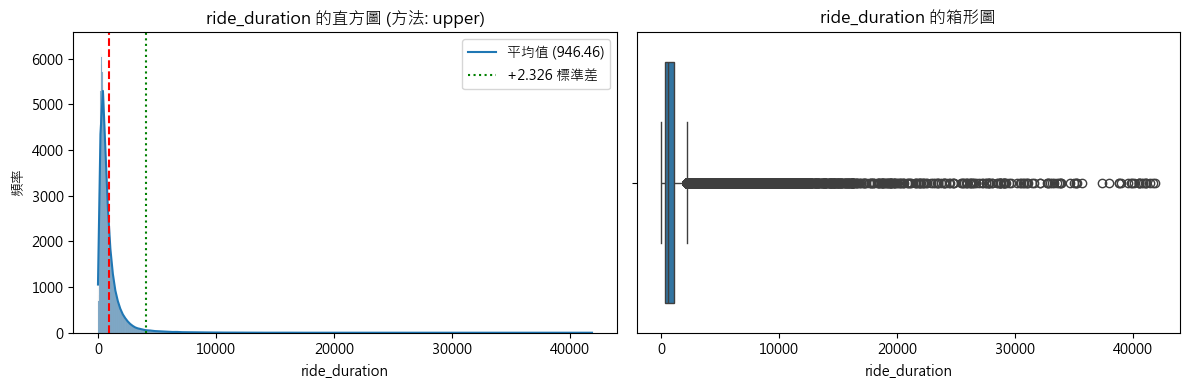


--- 總結 ---
已檢查的欄位及其方法: {'ride_duration': 'upper'}
在已檢查欄位中根據各自方法識別出的總唯一極端值行數: 4886
識別為極端值的行佔總行數的百分比: 2.27%


In [ ]:
def identify_outliers_zscore(df, columns, threshold=3, method='both'):
    """
    使用 Z 分數方法，識別 DataFrame 中指定數值欄位的潛在極端值。
    可選擇進行雙尾、僅上限或僅下限的檢查。

    打印摘要統計數據，並為每個欄位視覺化原始分佈。

    Args:
        df (pd.DataFrame): 輸入的 DataFrame。
        columns (list or dict):
            - list: 要檢查極端值的欄位名稱列表 (對所有欄位應用相同的 method)。
            - dict: 字典，鍵為欄位名，值為該欄位使用的檢查方法
                    ('both', 'upper', 'lower')。
        threshold (float): 定義極端值的 Z 分數閾值（預設值：3）。
        method (str):
            當 columns 為列表時，應用於所有欄位的預設檢查方法：
            'both' (檢查上下限), 'upper' (僅檢查上限), 'lower' (僅檢查下限)。
            如果 columns 是字典，則此參數被忽略。預設值：'both'。

    Returns:
        pd.DataFrame: 包含在 *任何* 指定欄位中根據其指定方法被識別為極端值的行的 DataFrame。
                      如果未找到極端值或欄位無效，則返回空的 DataFrame。
        set: 包含被識別為極端值的行的索引集合。
    """
    # --- 設定 Matplotlib 支持中文顯示 ---
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False
    # --- 設定完成 ---

    if not isinstance(df, pd.DataFrame):
        print("錯誤：輸入 'df' 必須是 pandas DataFrame。")
        return pd.DataFrame(), set()
    if not isinstance(columns, (list, dict)):
        print("錯誤：輸入 'columns' 必須是列表或字典。")
        return pd.DataFrame(), set()

    outlier_indices = set()
    print(f"--- 使用 Z 分數識別極端值 (閾值 = {threshold}) ---")
    print(f"檢查前的 DataFrame 維度: {df.shape}")

    valid_columns_checked = []
    columns_to_iterate = columns if isinstance(columns, dict) else {col: method for col in columns}

    for col, col_method in columns_to_iterate.items():
        # 驗證方法參數
        valid_methods = ['both', 'upper', 'lower']
        if col_method not in valid_methods:
            print(f"\n警告：欄位 '{col}' 的方法 '{col_method}' 無效。將使用預設 'both'。")
            col_method = 'both'

        # 檢查欄位是否存在且為數值類型
        if col not in df.columns:
            print(f"\n警告：欄位 '{col}' 在 DataFrame 中未找到。跳過。")
            continue
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"\n警告：欄位 '{col}' 不是數值類型。跳過 Z 分數計算。")
            continue

        valid_columns_checked.append(col)
        print(f"\n--- 檢查欄位: '{col}' (方法: {col_method}) ---")

        col_data = df[col].dropna()
        if col_data.empty:
            print("  此欄位只包含 NaN 值。跳過。")
            continue

        mean = col_data.mean()
        std = col_data.std()
        print(f"  平均值: {mean:.4f}")
        print(f"  標準差: {std:.4f}")

        if std == 0:
            print("  標準差為零。無法計算 Z 分數。")
            # ... (視覺化標準差為零的代碼保持不變) ...
            plt.figure(figsize=(10, 4))
            sns.histplot(col_data, kde=False, bins=min(10, col_data.nunique()))
            plt.title(f'{col} 的分佈 (標準差 = 0)')
            plt.xlabel(col)
            plt.ylabel('頻率')
            plt.tight_layout()
            plt.show()
            continue

        # 計算 *原始* Z 分數 (保留正負號)
        z_scores = (col_data - mean) / std

        # 根據指定方法找到極端值索引
        col_outlier_indices = pd.Index([]) # 初始化為空索引
        if col_method == 'both':
            col_outlier_indices = col_data[np.abs(z_scores) > threshold].index
            print_method = f"|Z| > {threshold}"
        elif col_method == 'upper':
            col_outlier_indices = col_data[z_scores > threshold].index
            print_method = f"Z > {threshold}"
        elif col_method == 'lower':
            col_outlier_indices = col_data[z_scores < -threshold].index
            print_method = f"Z < -{threshold}"

        num_outliers = len(col_outlier_indices)
        print(f"  找到的極端值 ({print_method}): {num_outliers} 個 (佔總行數的 {num_outliers / len(df) * 100:.2f}%)")
        outlier_indices.update(col_outlier_indices)

        # --- 視覺化 ---
        print("  視覺化原始分佈...")
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # 直方圖
        sns.histplot(col_data, kde=True, ax=axes[0])
        axes[0].set_title(f'{col} 的直方圖 (方法: {col_method})')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('頻率')
        axes[0].axvline(mean, color='r', linestyle='--', label=f'平均值 ({mean:.2f})')
        
        # 根據方法繪製閾值線
        legend_handles = [axes[0].get_lines()[0]] # 先加入平均值線的 handle
        legend_labels = [f'平均值 ({mean:.2f})']
        if col_method in ['both', 'upper']:
            line_upper = axes[0].axvline(mean + threshold * std, color='g', linestyle=':', label=f'+{threshold} 標準差')
            legend_handles.append(line_upper)
            legend_labels.append(f'+{threshold} 標準差')
        if col_method in ['both', 'lower']:
            line_lower = axes[0].axvline(mean - threshold * std, color='purple', linestyle=':', label=f'-{threshold} 標準差') # 改用紫色區分
            legend_handles.append(line_lower)
            legend_labels.append(f'-{threshold} 標準差')
        axes[0].legend(handles=legend_handles, labels=legend_labels) # 使用 handles 和 labels 確保圖例正確

        # 箱形圖
        sns.boxplot(x=col_data, ax=axes[1])
        axes[1].set_title(f'{col} 的箱形圖')
        axes[1].set_xlabel(col)

        plt.tight_layout()
        plt.show()

    # --- 總結 ---
    total_unique_outliers = len(outlier_indices)
    if not valid_columns_checked:
         print("\n未檢查任何有效的數值欄位。")
         return pd.DataFrame(), set()

    print(f"\n--- 總結 ---")
    print(f"已檢查的欄位及其方法: {columns_to_iterate}")
    print(f"在已檢查欄位中根據各自方法識別出的總唯一極端值行數: {total_unique_outliers}")
    print(f"識別為極端值的行佔總行數的百分比: {total_unique_outliers / len(df) * 100:.2f}%")

    if outlier_indices:
        outlier_df = df.loc[list(outlier_indices)].copy()
        return outlier_df, outlier_indices
    else:
        print("根據標準未找到極端值。")
        return pd.DataFrame(), set()


#---------------------------------檢查遺漏值----------------------------------------


# 識別 'ride_duration' 的上限極端值 (例如，只關心騎太久的)
columns_to_check_upper = {'ride_duration': 'upper'}
outlier_rows_df_upper, outlier_idx_set_upper = identify_outliers_zscore(
    df_cleaned4,
    columns_to_check_upper,
    threshold=2.326
)



--- 使用 Z 分數移除極端值 (閾值 = 2.326) ---
原始 DataFrame 維度: (215669, 14)
將應用的檢查方法: {'ride_duration': 'upper'}
  標記 4886 行，因其在 'ride_duration' 中存在極端值 (Z > 2.326)，準備移除。

--- 移除總結 ---
已檢查的欄位: ['ride_duration']
總共移除的行數: 4886
移除的行數佔比: 2.27%
最終 DataFrame 維度: (210783, 14)

--- 視覺化移除極端值後的分佈 ---
  繪製欄位 'ride_duration' (移除後)...


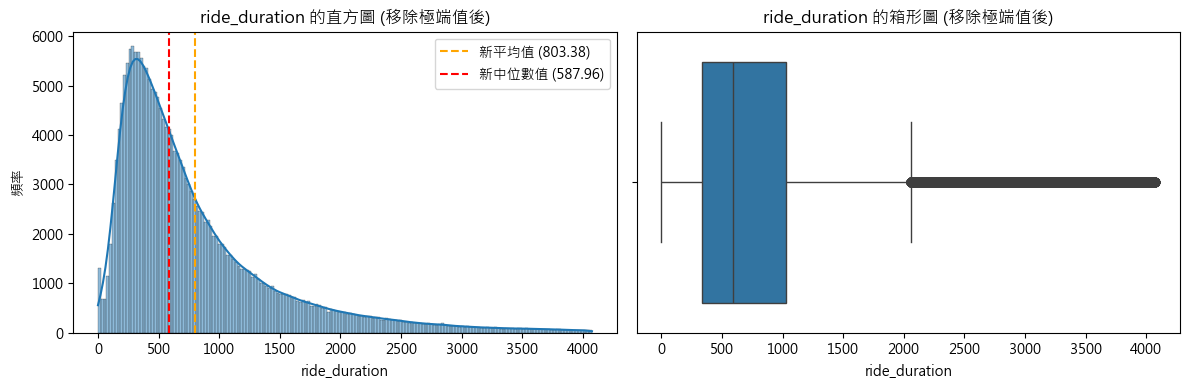

"\n    根據 Z 分數方法，從 DataFrame 中移除在 *任何* 指定數值欄位中包含極端值的行。\n    可選擇進行雙尾、僅上限或僅下限的檢查，並可選擇視覺化移除後的分佈。\n\n    Args:\n        df (pd.DataFrame): 輸入的 DataFrame。\n        columns (list or dict):\n            - list: 要檢查極端值的欄位名稱列表 (對所有欄位應用相同的 method)。\n            - dict: 字典，鍵為欄位名，值為該欄位使用的檢查方法\n                    ('both', 'upper', 'lower')。\n        threshold (float): 定義極端值的 Z 分數閾值（預設值：3）。\n        method (str):\n            當 columns 為列表時，應用於所有欄位的預設檢查方法：\n            'both' (檢查上下限), 'upper' (僅檢查上限), 'lower' (僅檢查下限)。\n            如果 columns 是字典，則此參數被忽略。預設值：'both'。\n        visualize_after (bool): 是否在移除極端值後視覺化受影響欄位的分佈 (預設值: True)。\n\n    Returns:\n        pd.DataFrame: 移除了極端值行的新 DataFrame。\n                      如果未移除任何極端值或欄位無效，則返回原始 DataFrame。\n"

In [ ]:
def remove_outliers_zscore(df, columns, threshold=3, method='both', visualize_after=True):
    """
    根據 Z 分數方法，從 DataFrame 中移除在 *任何* 指定數值欄位中包含極端值的行。
    可選擇進行雙尾、僅上限或僅下限的檢查，並可選擇視覺化移除後的分佈。

    Args:
        df (pd.DataFrame): 輸入的 DataFrame。
        columns (list or dict):
            - list: 要檢查極端值的欄位名稱列表 (對所有欄位應用相同的 method)。
            - dict: 字典，鍵為欄位名，值為該欄位使用的檢查方法
                    ('both', 'upper', 'lower')。
        threshold (float): 定義極端值的 Z 分數閾值（預設值：3）。
        method (str):
            當 columns 為列表時，應用於所有欄位的預設檢查方法：
            'both' (檢查上下限), 'upper' (僅檢查上限), 'lower' (僅檢查下限)。
            如果 columns 是字典，則此參數被忽略。預設值：'both'。
        visualize_after (bool): 是否在移除極端值後視覺化受影響欄位的分佈 (預設值: True)。

    Returns:
        pd.DataFrame: 移除了極端值行的新 DataFrame。
                      如果未移除任何極端值或欄位無效，則返回原始 DataFrame。
    """
    # --- 設定 Matplotlib 支持中文顯示 ---
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False
    # --- 設定完成 ---

    if not isinstance(df, pd.DataFrame):
        print("錯誤：輸入 'df' 必須是 pandas DataFrame。")
        return df
    if not isinstance(columns, (list, dict)):
        print("錯誤：輸入 'columns' 必須是列表或字典。")
        return df

    print(f"\n--- 使用 Z 分數移除極端值 (閾值 = {threshold}) ---")
    original_rows = len(df)
    print(f"原始 DataFrame 維度: {df.shape}")

    rows_to_keep_mask = pd.Series(True, index=df.index)
    valid_columns_checked = [] # 記錄實際用於檢查的欄位
    columns_to_iterate = columns if isinstance(columns, dict) else {col: method for col in columns}
    print(f"將應用的檢查方法: {columns_to_iterate}")

    # --- 標記極端值 ---
    for col, col_method in columns_to_iterate.items():
        valid_methods = ['both', 'upper', 'lower']
        if col_method not in valid_methods:
            print(f"警告：欄位 '{col}' 的方法 '{col_method}' 無效。將使用預設 'both'。")
            col_method = 'both'

        if col not in df.columns:
            print(f"警告：欄位 '{col}' 未找到。跳過。")
            continue
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"警告：欄位 '{col}' 不是數值類型。跳過。")
            continue

        valid_columns_checked.append(col) # 只有有效欄位才加入列表
        col_data = df[col].dropna()
        if col_data.empty:
            continue

        mean = col_data.mean()
        std = col_data.std()
        if std == 0:
             continue

        z_scores = (col_data - mean) / std
        col_outlier_indices = pd.Index([])
        print_method = "" # 初始化 print_method
        if col_method == 'both':
            col_outlier_indices = col_data[np.abs(z_scores) > threshold].index
            print_method = f"|Z| > {threshold}"
        elif col_method == 'upper':
            col_outlier_indices = col_data[z_scores > threshold].index
            print_method = f"Z > {threshold}"
        elif col_method == 'lower':
            col_outlier_indices = col_data[z_scores < -threshold].index
            print_method = f"Z < -{threshold}"

        if not col_outlier_indices.empty:
             print(f"  標記 {len(col_outlier_indices)} 行，因其在 '{col}' 中存在極端值 ({print_method})，準備移除。")
             rows_to_keep_mask.loc[col_outlier_indices] = False

    # --- 應用遮罩移除極端值 ---
    df_cleaned = df[rows_to_keep_mask].copy()

    # --- 報告移除結果 ---
    rows_removed = original_rows - len(df_cleaned)
    print(f"\n--- 移除總結 ---")
    if not valid_columns_checked:
         print("未檢查任何有效的數值欄位。未移除任何行。")
         print(f"最終 DataFrame 維度: {df_cleaned.shape}") # 仍然打印最終維度
    elif rows_removed > 0:
        print(f"已檢查的欄位: {valid_columns_checked}")
        print(f"總共移除的行數: {rows_removed}")
        print(f"移除的行數佔比: {rows_removed / original_rows * 100:.2f}%")
        print(f"最終 DataFrame 維度: {df_cleaned.shape}")
    else:
        print(f"已檢查的欄位: {valid_columns_checked}")
        print("未找到符合標準的極端值。未移除任何行。")
        print(f"最終 DataFrame 維度: {df_cleaned.shape}")

    # --- (新增) 視覺化移除後的分佈 ---
    if visualize_after and rows_removed > 0 and valid_columns_checked: # 只有在實際移除且有檢查欄位時才繪圖
        print("\n--- 視覺化移除極端值後的分佈 ---")
        for col in valid_columns_checked: # 只繪製實際檢查過的欄位
            print(f"  繪製欄位 '{col}' (移除後)...")
            col_data_cleaned = df_cleaned[col].dropna()

            if col_data_cleaned.empty:
                print(f"    欄位 '{col}' 在移除極端值後已無有效數據。無法繪圖。")
                continue
            if col_data_cleaned.nunique() == 1: # 如果清理後只剩一個值
                print(f"    欄位 '{col}' 在移除極端值後只剩下一個唯一值: {col_data_cleaned.iloc[0]}")
                plt.figure(figsize=(10, 4))
                sns.histplot(col_data_cleaned, kde=False, bins=1)
                plt.title(f'{col} 的分佈 (移除極端值後 - 僅一個值)')
                plt.xlabel(col)
                plt.ylabel('頻率')
                plt.tight_layout()
                plt.show()
                continue

            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # 直方圖
            sns.histplot(col_data_cleaned, kde=True, ax=axes[0])
            axes[0].set_title(f'{col} 的直方圖 (移除極端值後)')
            axes[0].set_xlabel(col)
            axes[0].set_ylabel('頻率')
            # (可選) 可以在這裡添加清理後數據的平均值線
            mean_cleaned = col_data_cleaned.mean()
            median_cleaned = col_data_cleaned.median()
            axes[0].axvline(mean_cleaned, color='orange', linestyle='--', label=f'新平均值 ({mean_cleaned:.2f})')
            axes[0].axvline(median_cleaned, color='red', linestyle='--', label=f'新中位數值 ({median_cleaned:.2f})')
            axes[0].legend()


            # 箱形圖
            sns.boxplot(x=col_data_cleaned, ax=axes[1])
            axes[1].set_title(f'{col} 的箱形圖 (移除極端值後)')
            axes[1].set_xlabel(col)

            plt.tight_layout()
            plt.show()
    elif visualize_after:
         print("\n未移除任何行或未檢查有效欄位，無需繪製移除後的分佈圖。")


    return df_cleaned

#---------------------------------使用函數----------------------------------------

# 移除 'ride_duration' 的上限極端值，並視覺化移除後結果
columns_for_removal = {'ride_duration': 'upper'}
df_cleaned4 = remove_outliers_zscore(
    df_cleaned4,
    columns_for_removal,
    threshold=2.326, #(99% 單尾)
    visualize_after=True # 確保設置為 True
)

"""
    根據 Z 分數方法，從 DataFrame 中移除在 *任何* 指定數值欄位中包含極端值的行。
    可選擇進行雙尾、僅上限或僅下限的檢查，並可選擇視覺化移除後的分佈。

    Args:
        df (pd.DataFrame): 輸入的 DataFrame。
        columns (list or dict):
            - list: 要檢查極端值的欄位名稱列表 (對所有欄位應用相同的 method)。
            - dict: 字典，鍵為欄位名，值為該欄位使用的檢查方法
                    ('both', 'upper', 'lower')。
        threshold (float): 定義極端值的 Z 分數閾值（預設值：3）。
        method (str):
            當 columns 為列表時，應用於所有欄位的預設檢查方法：
            'both' (檢查上下限), 'upper' (僅檢查上限), 'lower' (僅檢查下限)。
            如果 columns 是字典，則此參數被忽略。預設值：'both'。
        visualize_after (bool): 是否在移除極端值後視覺化受影響欄位的分佈 (預設值: True)。

    Returns:
        pd.DataFrame: 移除了極端值行的新 DataFrame。
                      如果未移除任何極端值或欄位無效，則返回原始 DataFrame。
"""


#### Brief Summary

針對ride_duration數值行數據，進行極端值移除。  
移除後數據樣本為4,310,554筆。

In [38]:
df_cleaned4.to_csv('df_cleaned4.csv', index=False) # 儲存清理後的數據

## 3 Data Exploration and Analyze

In [39]:
df_analyzed = pd.read_csv('df_cleaned4.csv')
print('已成功讀取df_analyzed.csv檔案')

已成功讀取df_analyzed.csv檔案


In [40]:
time_format = "%Y-%m-%d %H:%M:%S.%f"

df_analyzed['started_at'] = df_analyzed['started_at'].apply(standardize_datetime_format)
df_analyzed['ended_at'] = df_analyzed['ended_at'].apply(standardize_datetime_format)

df_analyzed['started_at'] = pd.to_datetime(df_analyzed['started_at'], format = time_format)
df_analyzed['ended_at'] = pd.to_datetime(df_analyzed['ended_at'], format = time_format)

In [41]:
df_analyzed

ride_id  rideable_type              started_at  \
0       f34ddef264de3942  electric_bike 2024-03-11 23:02:20.000   
1       fb87761d98c9b6d0  electric_bike 2024-03-22 12:05:25.000   
2       6c60b75b62ec71fd  electric_bike 2024-03-25 16:00:41.000   
3       75c338d5b850ed3e  electric_bike 2024-03-20 07:31:09.000   
4       129e011f1c9ac2cc   classic_bike 2024-03-06 17:20:44.000   
...                  ...            ...                     ...   
210778  98ab41f5332c3d60  electric_bike 2025-02-10 17:51:23.158   
210779  702ddcec43c169b5   classic_bike 2025-02-16 19:57:48.250   
210780  38202047916a8f0d  electric_bike 2025-02-01 12:09:50.631   
210781  635eb258f9400365  electric_bike 2025-02-16 13:25:07.066   
210782  fdf067e309c14a82   classic_bike 2025-02-23 16:15:02.370   

                      ended_at               start_station_name  \
0      2024-03-11 23:03:03.000            dayton st & north ave   
1      2024-03-22 12:05:46.000         racine ave & belmont ave   
2      2024-03-25 16:04:24.000           dearborn st & adams st   
3      2024-03-20 07:31:23.000        western ave & gunnison st   
4      2024-03-06 17:21:15.000            wood st & chicago ave   
...                        ...                              ...   
210778 2025-02-10 17:59:26.866             peterson/ridge metra   
210779 2025-02-16 20:04:10.138  pine grove ave & irving park rd   
210780 2025-02-01 12:15:09.909         racine ave & belmont ave   
210781 2025-02-16 13:46:38.419              wells st & huron st   
210782 2025-02-23 16:22:13.616        larrabee st & webster ave   

       start_station_id                 end_station_name end_station_id  \
0                 13058            dayton st & north ave          13058   
1          ta1308000019         racine ave & belmont ave   ta1308000019   
2          ta1305000005              canal st & adams st          13011   
3                   445        western ave & gunnison st            445   
4                   637            wood st & chicago ave            637   
...                 ...                              ...            ...   
210778            24458              2112 w peterson ave   ka1504000155   
210779     ta1308000022  pine grove ave & irving park rd   ta1308000022   
210780     ta1308000019       burling st & diversey pkwy          13208   
210781     ta1306000012         paulina st & flournoy st   ka1504000104   
210782            13193       burling st & diversey pkwy          13208   

        start_lat  start_lng    end_lat    end_lng member_casual  \
0       41.910000 -87.650000  41.910000 -87.650000        member   
1       41.940000 -87.660000  41.940000 -87.660000        member   
2       41.880000 -87.630000  41.880000 -87.640000        member   
3       41.970000 -87.690000  41.970000 -87.690000        member   
4       41.895634 -87.672069  41.895634 -87.672069        member   
...           ...        ...        ...        ...           ...   
210778  41.991800 -87.674890  41.991178 -87.683593        casual   
210779  41.954383 -87.648043  41.954383 -87.648043        member   
210780  41.939743 -87.658865  41.933140 -87.647760        member   
210781  41.894722 -87.634362  41.873061 -87.669135        member   
210782  41.921822 -87.644140  41.933140 -87.647760        member   

        ride_duration  
0              43.000  
1              21.000  
2             223.000  
3              14.000  
4              31.000  
...               ...  
210778        483.708  
210779        381.888  
210780        319.278  
210781       1291.353  
210782        431.246  

[210783 rows x 14 columns]

### 3-1 Feature Engineering

思考點：
 - 用戶在不同時間特徵下是否有不同行為？ - 提取時間特徵

In [42]:
df_analyzed['month']= df_analyzed['started_at'].dt.month
df_analyzed['day_of_week'] = df_analyzed['started_at'].dt.day_name()
df_analyzed['hour_of_day'] = df_analyzed['started_at'].dt.hour
df_analyzed['is_weekend'] = df_analyzed['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
df_analyzed

ride_id  rideable_type              started_at  \
0       f34ddef264de3942  electric_bike 2024-03-11 23:02:20.000   
1       fb87761d98c9b6d0  electric_bike 2024-03-22 12:05:25.000   
2       6c60b75b62ec71fd  electric_bike 2024-03-25 16:00:41.000   
3       75c338d5b850ed3e  electric_bike 2024-03-20 07:31:09.000   
4       129e011f1c9ac2cc   classic_bike 2024-03-06 17:20:44.000   
...                  ...            ...                     ...   
210778  98ab41f5332c3d60  electric_bike 2025-02-10 17:51:23.158   
210779  702ddcec43c169b5   classic_bike 2025-02-16 19:57:48.250   
210780  38202047916a8f0d  electric_bike 2025-02-01 12:09:50.631   
210781  635eb258f9400365  electric_bike 2025-02-16 13:25:07.066   
210782  fdf067e309c14a82   classic_bike 2025-02-23 16:15:02.370   

                      ended_at               start_station_name  \
0      2024-03-11 23:03:03.000            dayton st & north ave   
1      2024-03-22 12:05:46.000         racine ave & belmont ave   
2      2024-03-25 16:04:24.000           dearborn st & adams st   
3      2024-03-20 07:31:23.000        western ave & gunnison st   
4      2024-03-06 17:21:15.000            wood st & chicago ave   
...                        ...                              ...   
210778 2025-02-10 17:59:26.866             peterson/ridge metra   
210779 2025-02-16 20:04:10.138  pine grove ave & irving park rd   
210780 2025-02-01 12:15:09.909         racine ave & belmont ave   
210781 2025-02-16 13:46:38.419              wells st & huron st   
210782 2025-02-23 16:22:13.616        larrabee st & webster ave   

       start_station_id                 end_station_name end_station_id  \
0                 13058            dayton st & north ave          13058   
1          ta1308000019         racine ave & belmont ave   ta1308000019   
2          ta1305000005              canal st & adams st          13011   
3                   445        western ave & gunnison st            445   
4                   637            wood st & chicago ave            637   
...                 ...                              ...            ...   
210778            24458              2112 w peterson ave   ka1504000155   
210779     ta1308000022  pine grove ave & irving park rd   ta1308000022   
210780     ta1308000019       burling st & diversey pkwy          13208   
210781     ta1306000012         paulina st & flournoy st   ka1504000104   
210782            13193       burling st & diversey pkwy          13208   

        start_lat  start_lng    end_lat    end_lng member_casual  \
0       41.910000 -87.650000  41.910000 -87.650000        member   
1       41.940000 -87.660000  41.940000 -87.660000        member   
2       41.880000 -87.630000  41.880000 -87.640000        member   
3       41.970000 -87.690000  41.970000 -87.690000        member   
4       41.895634 -87.672069  41.895634 -87.672069        member   
...           ...        ...        ...        ...           ...   
210778  41.991800 -87.674890  41.991178 -87.683593        casual   
210779  41.954383 -87.648043  41.954383 -87.648043        member   
210780  41.939743 -87.658865  41.933140 -87.647760        member   
210781  41.894722 -87.634362  41.873061 -87.669135        member   
210782  41.921822 -87.644140  41.933140 -87.647760        member   

        ride_duration  month day_of_week  hour_of_day  is_weekend  
0              43.000      3      Monday           23           0  
1              21.000      3      Friday           12           0  
2             223.000      3      Monday           16           0  
3              14.000      3   Wednesday            7           0  
4              31.000      3   Wednesday           17           0  
...               ...    ...         ...          ...         ...  
210778        483.708      2      Monday           17           0  
210779        381.888      2      Sunday           19           1  
210780        319.278      2    Saturday           12           1  
210781   

### 3-2 Exploratory Data Analaysis (EDA) Member vs Casual Users

#### 3-2-1 類別型態變數分組比較

思考點：
    - 從DATA-DRIVEN方法，找出分組變數之差異。

In [43]:
# 1. 定義分組欄位
group_col = 'member_casual'


# 2. 定義要比較的類別欄位列表
categorical_cols_to_compare = [
    'month',
    'day_of_week', # 假設已重命名或存在
    'hour_of_day',
    'is_weekend',
    'rideable_type',
]

# 3. 定義要比較的數值欄位列表
numerical_cols_to_compare = [
    'ride_duration'
]


# 可以針對不同的類別欄位進行分組和計算統計數據
df_classic_bike = df_analyzed[df_analyzed['rideable_type'] == 'classic_bike']

已設定 Matplotlib 字體參數。
--- 開始比較 'member_casual' 組別在【類別變數】上的差異 ---
將比較 'member_casual' 中的組別: ['member', 'casual']
使用 'member'(藍色) vs 'casual'(紅色) 調色盤。

--- 比較類別變數: 'month' ---

  類別佔比 (按組別):
month             1      2      3      4       5       6       7       8   \
member_casual                                                               
casual         0.71%  0.81%  4.21%  5.93%  12.35%  14.66%  16.39%  15.58%   
member         2.58%  2.75%  6.44%   7.8%  11.39%  11.71%  12.77%  12.03%   

month              9       10     11     12  
member_casual                                
casual         13.24%  10.52%   4.2%  1.41%  
member         11.63%  10.84%  6.55%  3.51%  

  視覺化 - 分組條形圖 (組內比例 %):


C:\Users\User\AppData\Local\Temp\ipykernel_38464\624074268.py:47: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_suitable_categorical = (pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]) or (pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() < 30))


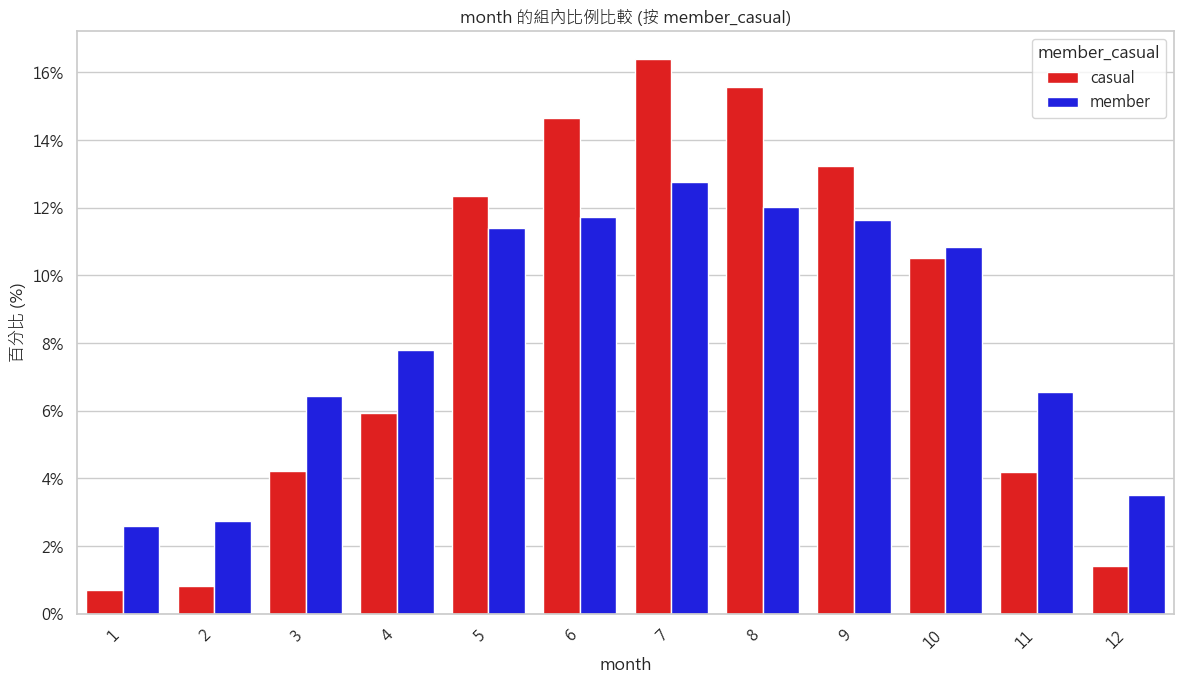


--- 比較類別變數: 'day_of_week' ---

  類別佔比 (按組別):
day_of_week   Friday  Monday Saturday  Sunday Thursday Tuesday Wednesday
member_casual                                                           
casual         14.5%  11.42%   22.43%  18.28%   11.46%  10.11%    11.81%
member         14.0%  14.55%   12.99%  11.81%   14.91%  15.44%    16.31%

  視覺化 - 分組條形圖 (組內比例 %):


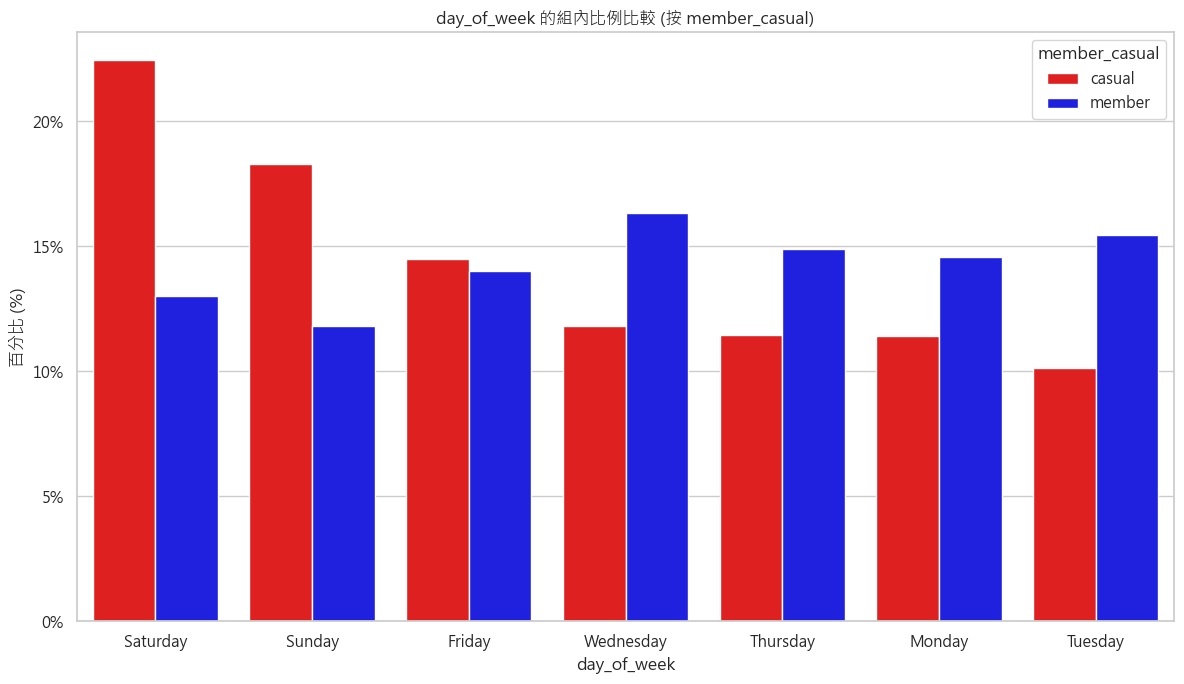

C:\Users\User\AppData\Local\Temp\ipykernel_38464\624074268.py:47: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_suitable_categorical = (pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]) or (pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() < 30))



--- 比較類別變數: 'hour_of_day' ---

  類別佔比 (按組別):
hour_of_day       0      1      2      3      4      5      6      7      8   \
member_casual                                                                  
casual         1.28%  0.98%  0.51%  0.24%  0.25%  0.48%  1.04%  2.07%  3.19%   
member         0.65%  0.39%  0.18%  0.13%  0.17%  0.93%  2.65%  5.45%  7.02%   

hour_of_day       9   ...     14     15     16      17     18     19     20  \
member_casual         ...                                                     
casual         3.64%  ...  7.54%  7.73%   8.9%   9.69%  8.72%  6.11%  4.31%   
member         4.91%  ...  5.53%  6.49%  8.98%  11.05%  8.47%  5.91%  4.14%   

hour_of_day       21     22     23  
member_casual                       
casual          3.2%  2.96%  2.01%  
member         2.88%  1.99%  1.17%  

[2 rows x 24 columns]

  視覺化 - 分組條形圖 (組內比例 %):


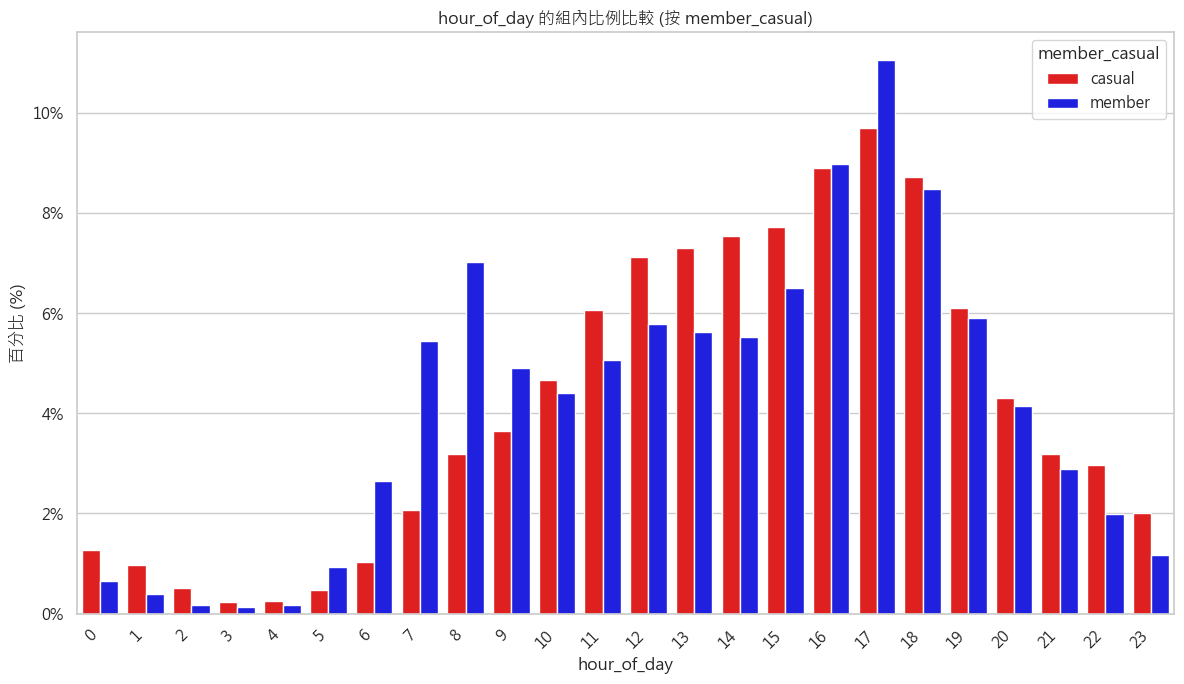


--- 比較類別變數: 'is_weekend' ---

  類別佔比 (按組別):
is_weekend          0       1
member_casual                
casual         59.29%  40.71%
member         75.21%  24.79%

  視覺化 - 分組條形圖 (組內比例 %):


C:\Users\User\AppData\Local\Temp\ipykernel_38464\624074268.py:47: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_suitable_categorical = (pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]) or (pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() < 30))


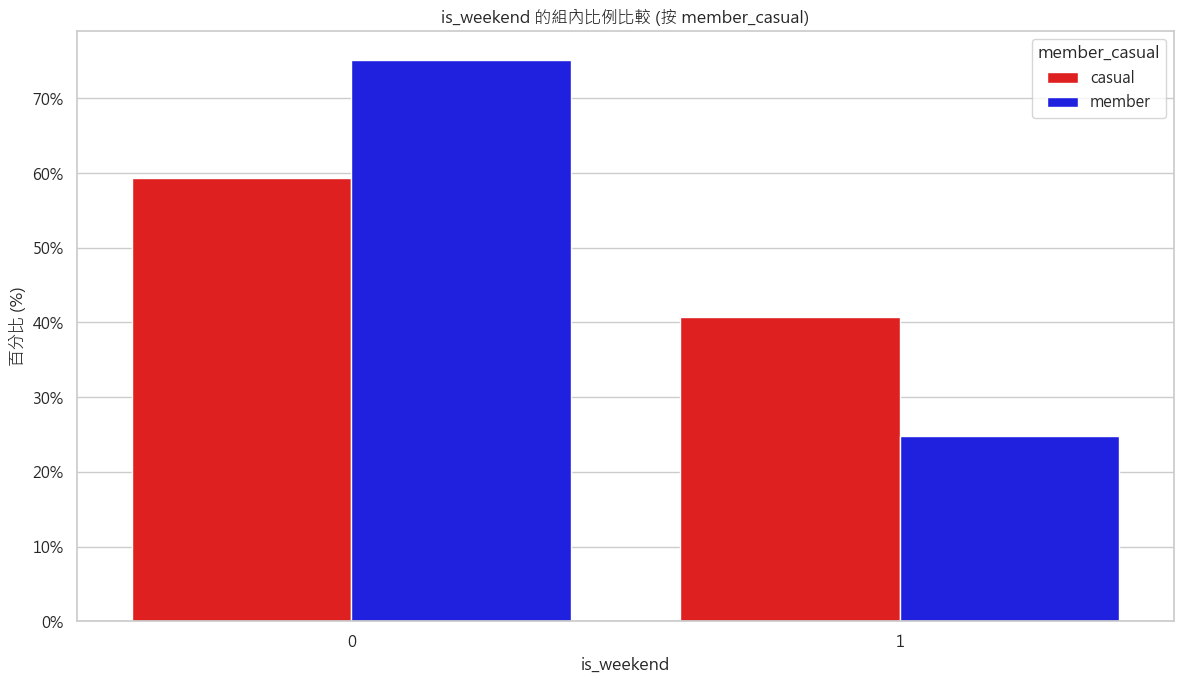


--- 比較類別變數: 'rideable_type' ---

  類別佔比 (按組別):
rideable_type classic_bike
member_casual             
casual              100.0%
member              100.0%

  視覺化 - 分組條形圖 (組內比例 %):


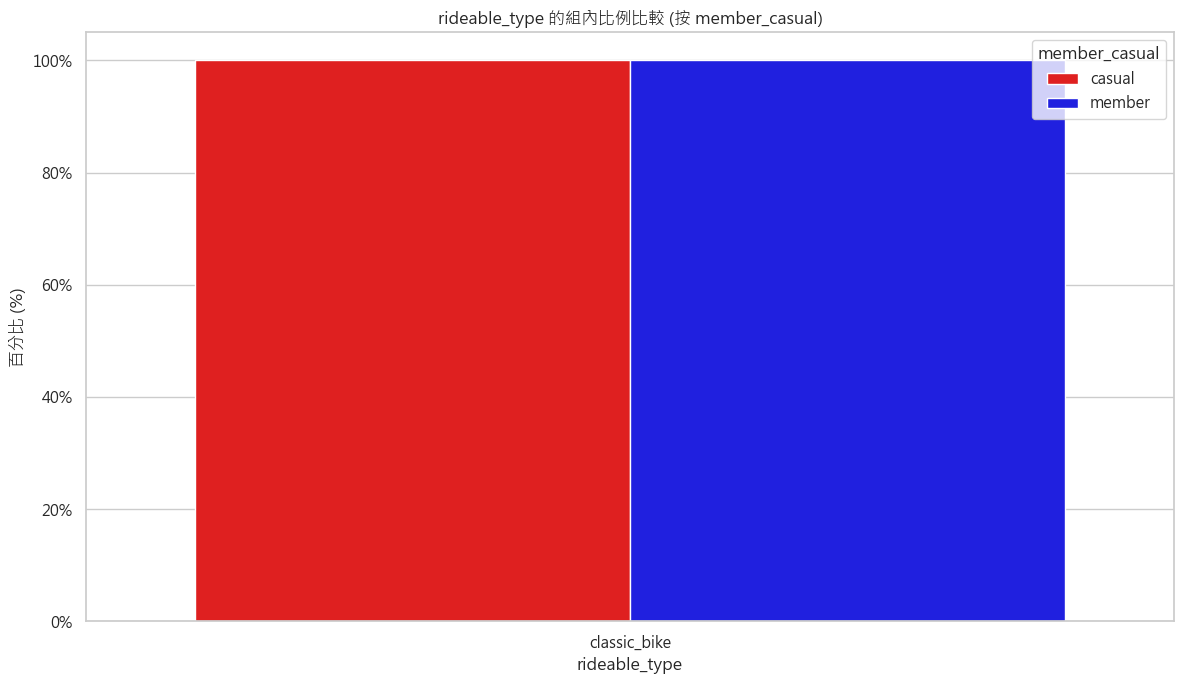


--- 'member_casual' 組別在【類別變數】上的比較分析完成 ---


In [44]:
# --- 設定 Matplotlib/Seaborn (全局設定) ---
# 先設定 Seaborn 主題
sns.set_theme(style="whitegrid")
# 設定特定的 Matplotlib rcParams
try:
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False
    print("已設定 Matplotlib 字體參數。")
except Exception as e:
    print(f"設定 Matplotlib 字體時發生錯誤: {e}")
    print("請確保 'Microsoft JhengHei' 或你選擇的字體已正確安裝。")


def compare_categorical_groups(df, group_column, categorical_columns):
    """
    執行 EDA，比較指定分組欄位中不同組別在【類別變數】上的分佈差異。
    使用交叉表顯示比例，使用分組條形圖顯示【組內比例】。

    Args:
        df (pd.DataFrame): 輸入的已清理 DataFrame。
        group_column (str): 作為分組依據的欄位名稱 (例如 'member_casual')。
        categorical_columns (list): 包含要比較的【類別型】欄位名稱的列表。
                                    (也適用於低基數的數值型欄位)。
    """
    print(f"--- 開始比較 '{group_column}' 組別在【類別變數】上的差異 ---")

    # --- 輸入驗證 ---
    # (保持不變)
    if not isinstance(df, pd.DataFrame): print("錯誤：輸入 'df' 必須是 pandas DataFrame。"); return
    if group_column not in df.columns: print(f"錯誤：分組欄位 '{group_column}' 不在 DataFrame 中。"); return
    if not isinstance(categorical_columns, list): print("錯誤：'categorical_columns' 必須是一個列表。"); return
    groups = df[group_column].unique()
    if len(groups) < 2: print(f"錯誤：分組欄位 '{group_column}' 只有少於 2 個唯一組別，無法進行比較。"); return
    print(f"將比較 '{group_column}' 中的組別: {list(groups)}")

    # 獲取分組的顏色
    # (保持不變)
    try:
        if group_column == 'member_casual': palette = {'member': 'blue', 'casual': 'red'}; print("使用 'member'(藍色) vs 'casual'(紅色) 調色盤。")
        else: palette = sns.color_palette(n_colors=len(groups)); print(f"為 {len(groups)} 個組別自動生成調色盤。")
    except Exception: palette = None; print("無法設置特定調色盤，將使用預設顏色。")

    # --- 遍歷要比較的類別欄位 ---
    for col in categorical_columns:
        if col not in df.columns: print(f"\n警告：欄位 '{col}' 不在 DataFrame 中。跳過此欄位。"); continue
        if col == group_column: print(f"\n提示：欄位 '{col}' 是分組欄位本身。跳過比較。"); continue
        is_suitable_categorical = (pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]) or (pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() < 30))
        if not is_suitable_categorical: print(f"\n警告：欄位 '{col}' (類型: {df[col].dtype}, 唯一值: {df[col].nunique()}) 不適合進行類別分析。跳過。"); continue

        print(f"\n--- 比較類別變數: '{col}' ---")

        # 1. 統計摘要 - 計算比例 (保持不變)
        print("\n  類別佔比 (按組別):")
        try:
            cross_tab = pd.crosstab(index=df[group_column], columns=df[col], normalize='index')
            print((cross_tab * 100).round(2).astype(str) + '%')
        except Exception as e:
            print(f"    計算交叉表時出錯: {e}")

        # --- 修改：計算比例數據用於繪圖 ---
        try:
            # 計算每個 group 內，col 各類別的比例
            proportion_data = df.groupby(group_column, observed=True)[col].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
            # observed=True 避免顯示未使用的類別組合

            if proportion_data.empty:
                 print(f"    欄位 '{col}' 計算比例後數據為空。跳過繪圖。")
                 continue

            # 2. 視覺化 - 分組條形圖 (顯示【比例】)
            print("\n  視覺化 - 分組條形圖 (組內比例 %):")
            plt.figure(figsize=(12, 7))
            # 使用 barplot，x 是類別，y 是計算好的比例，hue 是分組
            ax = sns.barplot(
                data=proportion_data,
                x=col,
                y='percentage',
                hue=group_column,
                palette=palette,
                dodge=True # 保持並排顯示
            )
            ax.set_title(f'{col} 的組內比例比較 (按 {group_column})') # 更新標題
            ax.set_xlabel(col)
            ax.set_ylabel('百分比 (%)') # 更新 Y 軸標籤
            ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format)) # 格式化 Y 軸為百分比

            # 根據唯一值數量決定是否旋轉標籤
            if df[col].nunique() > 10:
                 plt.xticks(rotation=45, ha='right')
            else:
                 plt.xticks(rotation=0)
            ax.legend(title=group_column)
            plt.tight_layout()
            plt.show()
            # --- 抑制結束 ---

        except Exception as e:
            print(f"    計算比例或繪製條形圖時出錯: {e}")

    print(f"\n--- '{group_column}' 組別在【類別變數】上的比較分析完成 ---")


# --- 使用函數開始分析類別函數 ---
# (假設 df_analyzed, group_col, categorical_cols_to_compare 已定義)
compare_categorical_groups(df_classic_bike, group_col, categorical_cols_to_compare)

#### 3-2-2 分析數值型態在分類組別上的差異。

已設定 Matplotlib 字體參數。
--- 開始比較 'member_casual' 組別在【數值變數】上的差異 ---
將比較 'member_casual' 中的組別: ['member', 'casual']
使用 'member'(藍色) vs 'casual'(紅色) 調色盤。

--- 比較數值變數: 'ride_duration' ---

  統計摘要 (按組別):
               count         mean   median         std  min       max
member_casual                                                        
casual         43718  1153.863668  889.927  865.827548  0.0  4075.098
member         82876   749.331999  553.251  613.319637  1.0  4074.132

  視覺化 - 小提琴圖:


C:\Users\User\AppData\Local\Temp\ipykernel_38464\2223131963.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=group_column, y=col, palette=palette, inner='quartile') # inner='quartile' 顯示四分位數


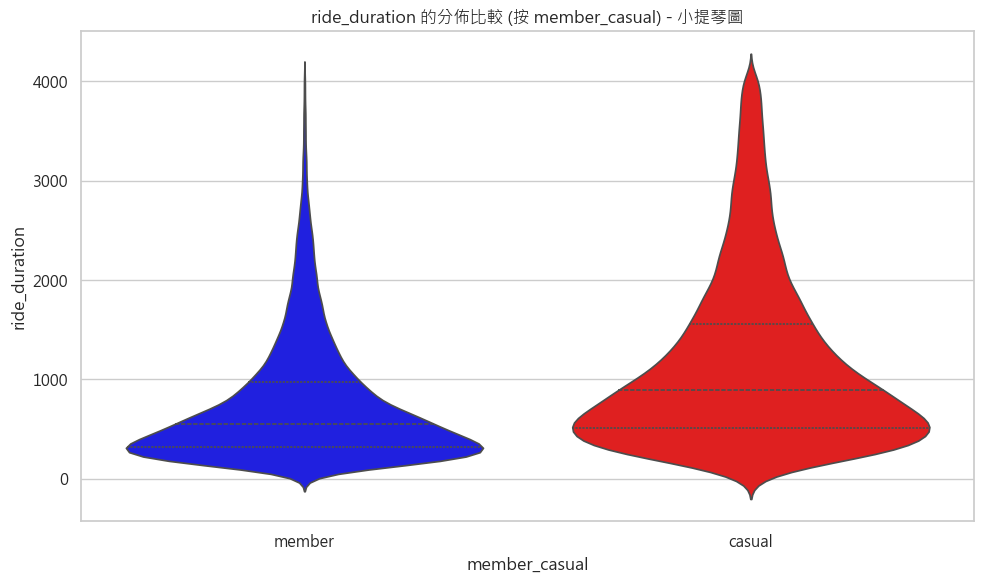


  視覺化 - 疊加直方圖/KDE:
    繪製直方圖/KDE時出錯: name 'warnings' is not defined

--- 'member_casual' 組別在【數值變數】上的比較分析完成 ---


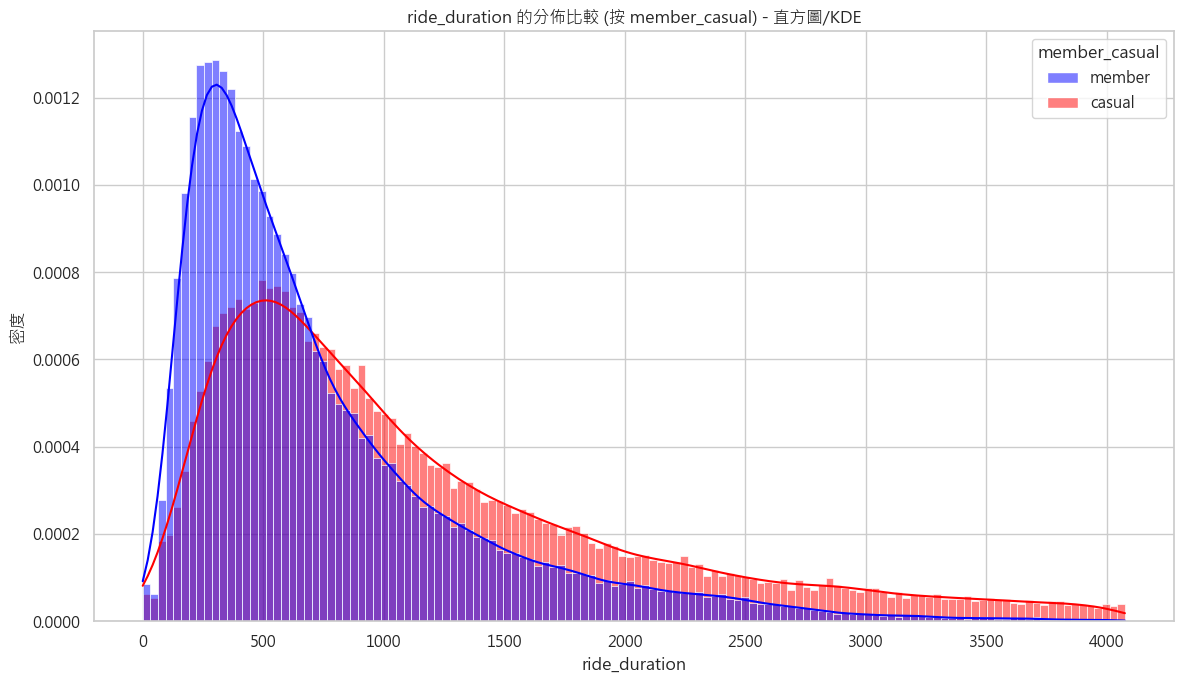

In [45]:

#設定 Seaborn 主題
sns.set_theme(style="whitegrid")

# 2.設定 Matplotlib rcParams 來覆蓋主題中的字體設定
try:
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 繁體中文 (微軟正黑體)
    # 或其他你確認可用的字體
    plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題
    print("已設定 Matplotlib 字體參數。")
except Exception as e:
    print(f"設定 Matplotlib 字體時發生錯誤: {e}")
    print("請確保 'Microsoft JhengHei' 或你選擇的字體已正確安裝。")

def compare_numerical_groups(df, group_column, numerical_columns):
    """
    執行 EDA，比較指定分組欄位中不同組別在【數值變數】上的分佈差異。
    使用統計摘要、小提琴圖和疊加直方圖(帶KDE)。

    Args:
        df (pd.DataFrame): 輸入的已清理 DataFrame。
        group_column (str): 作為分組依據的欄位名稱 (例如 'member_casual')。
        numerical_columns (list): 包含要比較的【數值型】欄位名稱的列表。
    """
    print(f"--- 開始比較 '{group_column}' 組別在【數值變數】上的差異 ---")

    # --- 輸入驗證 ---
    if not isinstance(df, pd.DataFrame):
        print("錯誤：輸入 'df' 必須是 pandas DataFrame。")
        return
    if group_column not in df.columns:
        print(f"錯誤：分組欄位 '{group_column}' 不在 DataFrame 中。")
        return
    if not isinstance(numerical_columns, list):
        print("錯誤：'numerical_columns' 必須是一個列表。")
        return

    groups = df[group_column].unique()
    if len(groups) < 2:
        print(f"錯誤：分組欄位 '{group_column}' 只有少於 2 個唯一組別，無法進行比較。")
        return
    print(f"將比較 '{group_column}' 中的組別: {list(groups)}")

    # 獲取分組的顏色
    try:
        if group_column == 'member_casual':
             palette = {'member': 'blue', 'casual': 'red'}
             print("使用 'member'(藍色) vs 'casual'(紅色) 調色盤。")
        else:
             palette = sns.color_palette(n_colors=len(groups))
             print(f"為 {len(groups)} 個組別自動生成調色盤。")
    except Exception:
        palette = None
        print("無法設置特定調色盤，將使用預設顏色。")

    # --- 遍歷要比較的數值欄位 ---
    for col in numerical_columns:
        if col not in df.columns:
            print(f"\n警告：欄位 '{col}' 不在 DataFrame 中。跳過此欄位。")
            continue
        if col == group_column:
            print(f"\n提示：欄位 '{col}' 是分組欄位本身。跳過比較。")
            continue

        # 驗證是否為數值類型
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"\n警告：欄位 '{col}' (類型: {df[col].dtype}) 不是數值類型。跳過。")
            continue

        print(f"\n--- 比較數值變數: '{col}' ---")

        # 1. 統計摘要
        print("\n  統計摘要 (按組別):")
        try:
            stats = df.groupby(group_column)[col].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
            print(stats)
        except Exception as e:
            print(f"    計算統計摘要時出錯: {e}")

        # 2. 視覺化 - 小提琴圖
        print("\n  視覺化 - 小提琴圖:")
        try:
            plt.figure(figsize=(10, 6))
            sns.violinplot(data=df, x=group_column, y=col, palette=palette, inner='quartile') # inner='quartile' 顯示四分位數
            plt.title(f'{col} 的分佈比較 (按 {group_column}) - 小提琴圖')
            plt.xlabel(group_column)
            plt.ylabel(col)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"    繪製小提琴圖時出錯: {e}")


        # 3. 視覺化 - 疊加直方圖/KDE圖
        print("\n  視覺化 - 疊加直方圖/KDE:")
        try:
            use_log_scale = False
            # 檢查偏度前先移除 NaN 和無窮大值
            col_data_finite = df[col].replace([np.inf, -np.inf], np.nan).dropna()
            if not col_data_finite.empty:
                 skewness = col_data_finite.skew()
                 if skewness > 2 or skewness < -2:
                      if (col_data_finite > 0).all():
                           use_log_scale = True
                           print(f"    (偵測到數據偏斜 (偏度={skewness:.2f})，將在 X 軸使用對數尺度)")
                      else:
                           print(f"    (偵測到數據偏斜 (偏度={skewness:.2f})，但包含非正數值，無法使用對數尺度)")

            plt.figure(figsize=(12, 7))
            sns.histplot(data=df, x=col, hue=group_column, palette=palette,
                         kde=True, alpha=0.5, stat='density', common_norm=False,
                         log_scale=use_log_scale)
            plt.title(f'{col} 的分佈比較 (按 {group_column}) - 直方圖/KDE')
            plt.xlabel(f"{col}{' (對數尺度)' if use_log_scale else ''}")
            plt.ylabel('密度')
            plt.tight_layout()

           # --- 在顯示圖表前抑制警告 ---
            with warnings.catch_warnings():
                # 忽略所有 UserWarning，或者更精確地匹配消息
                # warnings.filterwarnings('ignore', category=UserWarning)
                warnings.filterwarnings('ignore', message='.*Glyph.*missing from current font.*', category=UserWarning)
                
            plt.show()
        except Exception as e:
            print(f"    繪製直方圖/KDE時出錯: {e}")


    print(f"\n--- '{group_column}' 組別在【數值變數】上的比較分析完成 ---")


    
# --- 使用函數開始分析數值型變數 ---

# 3. 執行數值變數比較分析
compare_numerical_groups(df_classic_bike, group_col, numerical_cols_to_compare)

#### 觀察總結：


1. 騎乘時間 - 月份 (Month):

- 觀察: 會員與非會員的使用高峰都在夏季（6-8月）。但非會員的季節性差異更明顯，夏季使用比例遠高於冬季；會員的使用在全年相對較平均，冬季下降幅度較小。
- 洞察: 非會員更偏向「好天氣」騎乘者，受季節影響大。會員則展現出更穩定的、可能是通勤或固定需求的騎乘模式。

2. 騎乘時間 - 星期幾 (Day of Week):

- 觀察: 非會員的使用高峰集中在週末（週六、週日）。會員的使用高峰則在週間（週一至週五）。
- 洞察: 非會員主要將自行車用於週末休閒娛樂。會員則主要在週間使用，很可能是用於通勤或日常代步。

3. 騎乘時間 - 小時 (Hour of Day):

- 觀察: 兩者在上下班尖峰時段（早上約8點，傍晚約17-18點）都有使用高峰。但會員在這些尖峰時段的比例 明顯 高於非會員，尤其是傍晚。非會員的使用則在下午時段（13-18點）分佈較廣。
- 洞察: 再次驗證會員的通勤模式。非會員的騎乘時間較分散，下午時段的休閒使用比例較高。

4. 騎乘時間 - 是否週末 (is_weekend):

- 觀察: 非會員在週末 (is_weekend=1) 的騎乘比例顯著高於平日 (is_weekend=0)。會員則絕大多數騎乘集中在平日 (is_weekend=0)。
- 洞察: 這個圖表總結了「星期幾」的發現，清楚顯示非會員偏好週末，會員偏好平日。

5. 騎乘時間長度 (ride_duration):

- 觀察: 會員的騎乘時間分佈更集中在較短的時間（圖表中山峰更高、更窄）。非會員的騎乘時間分佈較廣，且有更多比例的騎乘時間較長（圖表中山峰較矮胖、尾巴更長）。
- 洞察: 會員傾向於短途、頻繁的騎乘（符合通勤特性）。非會員的單次騎乘時間往往較長，可能用於觀光或較長時間的休閒活動。


### **核心洞察： **

非會員主要在週末和好天氣時進行較長時間的休閒騎乘。他們可能認為會員資格主要適用於高頻率的通勤者，而忽略了會員資格對其現有休閒騎乘模式也可能帶來的價值和便利性。轉換的關鍵在於 打破「會員=通勤者」的刻板印象，並量化會員資格對其休閒騎乘的潛在好處。

### 具體行銷洞察與策略建議：

1. 時機與情境觸發 (Timing & Contextual Triggering):

洞察: 非會員在週末或連續幾天內進行多次騎乘，或單次騎乘時間較長時，是他們最能體會到「累積成本」或「便利性需求」的時刻。

策略:

    - 即時成本比較: 在非會員結束一次騎乘（尤其是較長或週末騎乘）後，透過 App 推播或結帳頁面，即時顯示「若您是會員，本次騎乘可節省 X 元」或「本週末您已騎乘 X 次，費用為 Y 元，若升級會員月費僅需 Z 元」。

    - 週末結束提醒: 在週日晚上或週一早上，向週末有騎乘紀錄的非會員推播：「上週末騎得開心嗎？成為會員，讓未來的週末探索更自由、更划算！」

2. 價值溝通：量化休閒騎乘的會員利益 (Value Proposition for Leisure Rides):

洞察: 非會員可能低估了自己未來的休閒騎乘頻率，或未計算成為會員後，即使只是週末騎乘也能達到的「收支平衡點」。


總結來說， 轉換非會員的關鍵在於：在他們最活躍的 週末/休閒時段，用 具體的成本節省 和 提升的休閒體驗價值 來打動他們，並透過 低門檻的試用 降低他們的決策風險，最終讓他們意識到，即使主要是休閒使用，會員資格也能帶來實質的好處和更大的自由度。

In [46]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# --- 設定 Plotly 預設主題 (可選) ---
pio.templates.default = "plotly_white" # 使用類似 whitegrid 的主題

# --- (移除 Matplotlib/Seaborn 全局設定，因為 Plotly 會處理自己的樣式) ---
# sns.set_theme(style="whitegrid")
# try:
#     plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Plotly 通常會自動處理字體，或有其他設定方式
#     plt.rcParams['axes.unicode_minus'] = False
#     print("已設定 Matplotlib 字體參數。")
# except Exception as e:
#     print(f"設定 Matplotlib 字體時發生錯誤: {e}")
#     print("請確保 'Microsoft JhengHei' 或你選擇的字體已正確安裝。")


def compare_categorical_groups_plotly(df, group_column, categorical_columns):
    """
    執行 EDA，比較指定分組欄位中不同組別在【類別變數】上的分佈差異。
    使用交叉表顯示比例，使用 Plotly Express 產生互動式分組條形圖顯示【組內比例】。

    Args:
        df (pd.DataFrame): 輸入的已清理 DataFrame。
        group_column (str): 作為分組依據的欄位名稱 (例如 'member_casual')。
        categorical_columns (list): 包含要比較的【類別型】欄位名稱的列表。
                                    (也適用於低基數的數值型欄位)。
    """
    print(f"--- 開始比較 '{group_column}' 組別在【類別變數】上的差異 (使用 Plotly) ---")

    # --- 輸入驗證 ---
    if not isinstance(df, pd.DataFrame): print("錯誤：輸入 'df' 必須是 pandas DataFrame。"); return
    if group_column not in df.columns: print(f"錯誤：分組欄位 '{group_column}' 不在 DataFrame 中。"); return
    if not isinstance(categorical_columns, list): print("錯誤：'categorical_columns' 必須是一個列表。"); return
    groups = df[group_column].unique()
    if len(groups) < 2: print(f"錯誤：分組欄位 '{group_column}' 只有少於 2 個唯一組別，無法進行比較。"); return
    print(f"將比較 '{group_column}' 中的組別: {list(groups)}")

    # --- 獲取分組的顏色 (Plotly Express 可以自動處理，但我們也可以指定) ---
    color_map = None
    try:
        if group_column == 'member_casual':
            # Plotly Express 的 color_discrete_map 需要明確的鍵值對
            color_map = {'member': 'blue', 'casual': 'red'}
            print("使用 'member'(藍色) vs 'casual'(紅色) 調色盤。")
        # else: Plotly Express 會自動分配顏色
    except Exception as e:
        print(f"設定特定調色盤時發生錯誤: {e}。將使用 Plotly 預設顏色。")
        color_map = None

    # --- 遍歷要比較的類別欄位 ---
    for col in categorical_columns:
        if col not in df.columns: print(f"\n警告：欄位 '{col}' 不在 DataFrame 中。跳過此欄位。"); continue
        if col == group_column: print(f"\n提示：欄位 '{col}' 是分組欄位本身。跳過比較。"); continue
        # 檢查是否適合做類別分析 (稍微放寬數值型唯一值限制，因為 Plotly 可以處理更多類別)
        is_suitable_categorical = (pd.api.types.is_object_dtype(df[col]) or
                                   pd.api.types.is_categorical_dtype(df[col]) or
                                   (pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() < 50)) # 稍微放寬限制
        if not is_suitable_categorical:
            print(f"\n警告：欄位 '{col}' (類型: {df[col].dtype}, 唯一值: {df[col].nunique()}) 不適合進行類別分析。跳過。")
            continue

        print(f"\n--- 比較類別變數: '{col}' ---")

        # 1. 統計摘要 - 計算比例 (保持不變)
        print("\n  類別佔比 (按組別):")
        try:
            cross_tab = pd.crosstab(index=df[group_column], columns=df[col], normalize='index')
            print((cross_tab * 100).round(2).astype(str) + '%')
        except Exception as e:
            print(f"    計算交叉表時出錯: {e}")

        # --- 修改：計算比例數據用於繪圖 ---
        try:
            # 計算每個 group 內，col 各類別的比例
            # **重要：Plotly 的百分比格式化通常需要 0 到 1 之間的值**
            proportion_data = df.groupby(group_column, observed=True)[col].value_counts(normalize=True).rename('proportion').reset_index()
            # observed=True 避免顯示未使用的類別組合

            if proportion_data.empty:
                 print(f"    欄位 '{col}' 計算比例後數據為空。跳過繪圖。")
                 continue

            # 2. 視覺化 - 使用 Plotly Express 繪製互動式分組條形圖
            print("\n  視覺化 - 互動式分組條形圖 (組內比例 %):")

            fig = px.bar(
                proportion_data,
                x=col,
                y='proportion', # 使用 0-1 的比例值
                color=group_column, # 按組別分色
                barmode='group',    # 將條形圖分組並排 ('group') 或堆疊 ('stack')
                color_discrete_map=color_map, # 應用我們定義的顏色映射
                title=f'{col} 的組內比例比較 (按 {group_column})',
                labels={ # 自定義軸標籤和圖例標籤
                    'proportion': '百分比 (%)',
                    col: col, # X 軸標籤使用欄位名
                    group_column: group_column # 圖例標題使用分組欄位名
                },
                text_auto='.1%', # 在條形圖上顯示百分比標籤 (格式化為一位小數)
                                # 如果希望顯示原始比例值，可以用 text='proportion'，然後用 update_traces 設定格式
            )

            # --- 調整佈局 (Layout) ---
            # 格式化 Y 軸為百分比
            fig.update_layout(
                yaxis_tickformat='.0%', # 將 Y 軸刻度格式化為百分比 (例如 0.25 -> 25%)
                xaxis_title=col,       # 確保 X 軸標題正確
                yaxis_title='百分比 (%)', # 確保 Y 軸標題正確
                legend_title_text=group_column, # 設定圖例標題
                # height=500, # 可以取消註解來設定圖表高度
                # width=900   # 可以取消註解來設定圖表寬度
            )

            # 根據唯一值數量決定是否旋轉 X 軸標籤
            if df[col].nunique() > 10:
                 fig.update_layout(xaxis_tickangle=-45) # 旋轉 X 軸標籤
            # else: 預設不旋轉

            # --- 顯示圖表 ---
            fig.show()

        except Exception as e:
            print(f"    計算比例或繪製 Plotly 圖表時出錯: {e}")

    print(f"\n--- '{group_column}' 組別在【類別變數】上的比較分析完成 ---")

# --- 假設你的 DataFrame 和變數已定義 ---
# 假設 df_classic_bike, group_col, categorical_cols_to_compare 存在
# 例如:
group_col = 'member_casual'
categorical_cols_to_compare = ['month', 'day_of_week', 'hour_of_day', 'is_weekend'] # 你的類別欄位列表

# --- 使用新的 Plotly 函數 ---
compare_categorical_groups_plotly(df_classic_bike, group_col, categorical_cols_to_compare)

--- 開始比較 'member_casual' 組別在【類別變數】上的差異 (使用 Plotly) ---
將比較 'member_casual' 中的組別: ['member', 'casual']
使用 'member'(藍色) vs 'casual'(紅色) 調色盤。

--- 比較類別變數: 'month' ---

  類別佔比 (按組別):
month             1      2      3      4       5       6       7       8   \
member_casual                                                               
casual         0.71%  0.81%  4.21%  5.93%  12.35%  14.66%  16.39%  15.58%   
member         2.58%  2.75%  6.44%   7.8%  11.39%  11.71%  12.77%  12.03%   

month              9       10     11     12  
member_casual                                
casual         13.24%  10.52%   4.2%  1.41%  
member         11.63%  10.84%  6.55%  3.51%  

  視覺化 - 互動式分組條形圖 (組內比例 %):


C:\Users\User\AppData\Local\Temp\ipykernel_38464\4123484836.py:58: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(df[col]) or



--- 比較類別變數: 'day_of_week' ---

  類別佔比 (按組別):
day_of_week   Friday  Monday Saturday  Sunday Thursday Tuesday Wednesday
member_casual                                                           
casual         14.5%  11.42%   22.43%  18.28%   11.46%  10.11%    11.81%
member         14.0%  14.55%   12.99%  11.81%   14.91%  15.44%    16.31%

  視覺化 - 互動式分組條形圖 (組內比例 %):



--- 比較類別變數: 'hour_of_day' ---

  類別佔比 (按組別):
hour_of_day       0      1      2      3      4      5      6      7      8   \
member_casual                                                                  
casual         1.28%  0.98%  0.51%  0.24%  0.25%  0.48%  1.04%  2.07%  3.19%   
member         0.65%  0.39%  0.18%  0.13%  0.17%  0.93%  2.65%  5.45%  7.02%   

hour_of_day       9   ...     14     15     16      17     18     19     20  \
member_casual         ...                                                     
casual         3.64%  ...  7.54%  7.73%   8.9%   9.69%  8.72%  6.11%  4.31%   
member         4.91%  ...  5.53%  6.49%  8.98%  11.05%  8.47%  5.91%  4.14%   

hour_of_day       21     22     23  
member_casual                       
casual          3.2%  2.96%  2.01%  
member         2.88%  1.99%  1.17%  

[2 rows x 24 columns]

  視覺化 - 互動式分組條形圖 (組內比例 %):


C:\Users\User\AppData\Local\Temp\ipykernel_38464\4123484836.py:58: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead




--- 比較類別變數: 'is_weekend' ---

  類別佔比 (按組別):
is_weekend          0       1
member_casual                
casual         59.29%  40.71%
member         75.21%  24.79%

  視覺化 - 互動式分組條形圖 (組內比例 %):


C:\Users\User\AppData\Local\Temp\ipykernel_38464\4123484836.py:58: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead




--- 'member_casual' 組別在【類別變數】上的比較分析完成 ---


In [47]:
import pandas as pd
import numpy as np # Needed for inf check and skewness
import plotly.express as px
import plotly.io as pio
# import warnings # No longer needed for suppressing Matplotlib warnings

# --- 設定 Plotly 預設主題 (可選) ---
pio.templates.default = "plotly_white" # 使用類似 whitegrid 的主題

# --- (移除 Matplotlib/Seaborn 全局設定) ---

def compare_numerical_groups_plotly(df, group_column, numerical_columns):
    """
    執行 EDA，比較指定分組欄位中不同組別在【數值變數】上的分佈差異。
    使用統計摘要、互動式小提琴圖和互動式疊加直方圖 (使用 Plotly Express)。

    Args:
        df (pd.DataFrame): 輸入的已清理 DataFrame。
        group_column (str): 作為分組依據的欄位名稱 (例如 'member_casual')。
        numerical_columns (list): 包含要比較的【數值型】欄位名稱的列表。
    """
    print(f"--- 開始比較 '{group_column}' 組別在【數值變數】上的差異 (使用 Plotly) ---")

    # --- 輸入驗證 ---
    if not isinstance(df, pd.DataFrame):
        print("錯誤：輸入 'df' 必須是 pandas DataFrame。")
        return
    if group_column not in df.columns:
        print(f"錯誤：分組欄位 '{group_column}' 不在 DataFrame 中。")
        return
    if not isinstance(numerical_columns, list):
        print("錯誤：'numerical_columns' 必須是一個列表。")
        return

    groups = df[group_column].unique()
    if len(groups) < 2:
        print(f"錯誤：分組欄位 '{group_column}' 只有少於 2 個唯一組別，無法進行比較。")
        return
    print(f"將比較 '{group_column}' 中的組別: {list(groups)}")

    # --- 獲取分組的顏色 (Plotly Express 可以自動處理，但我們也可以指定) ---
    color_map = None
    try:
        if group_column == 'member_casual':
            # Plotly Express 的 color_discrete_map 需要明確的鍵值對
            color_map = {'member': 'blue', 'casual': 'red'}
            print("使用 'member'(藍色) vs 'casual'(紅色) 調色盤。")
        # else: Plotly Express 會自動分配顏色
    except Exception as e:
        print(f"設定特定調色盤時發生錯誤: {e}。將使用 Plotly 預設顏色。")
        color_map = None

    # --- 遍歷要比較的數值欄位 ---
    for col in numerical_columns:
        if col not in df.columns:
            print(f"\n警告：欄位 '{col}' 不在 DataFrame 中。跳過此欄位。")
            continue
        if col == group_column:
            print(f"\n提示：欄位 '{col}' 是分組欄位本身。跳過比較。")
            continue

        # 驗證是否為數值類型
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"\n警告：欄位 '{col}' (類型: {df[col].dtype}) 不是數值類型。跳過。")
            continue

        print(f"\n--- 比較數值變數: '{col}' ---")

        # 1. 統計摘要 (保持不變)
        print("\n  統計摘要 (按組別):")
        try:
            # 移除 NaN 和 inf 以確保統計計算正確
            stats = df.dropna(subset=[col]).replace([np.inf, -np.inf], np.nan).dropna(subset=[col])
            stats = stats.groupby(group_column)[col].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
            print(stats)
        except Exception as e:
            print(f"    計算統計摘要時出錯: {e}")

        # 2. 視覺化 - 互動式小提琴圖
        print("\n  視覺化 - 互動式小提琴圖:")
        try:
            fig_violin = px.violin(
                df,
                x=group_column,
                y=col,
                color=group_column, # 按組別分色
                color_discrete_map=color_map, # 應用顏色映射
                box=True, # 在小提琴內部顯示箱型圖 (包含四分位數)
                points=False, # 不顯示所有數據點 (可設為 'all' 或 'outliers')
                title=f'{col} 的分佈比較 (按 {group_column}) - 小提琴圖',
                labels={col: col, group_column: group_column} # 軸標籤
            )
            fig_violin.update_layout(
                 legend_title_text=group_column # 設定圖例標題
            )
            fig_violin.show()
        except Exception as e:
            print(f"    繪製 Plotly 小提琴圖時出錯: {e}")


        # 3. 視覺化 - 互動式疊加直方圖
        print("\n  視覺化 - 互動式疊加直方圖:")
        try:
            use_log_scale = False
            x_axis_label = col
            # 檢查偏度前先移除 NaN 和無窮大值
            col_data_finite = df[col].replace([np.inf, -np.inf], np.nan).dropna()

            if not col_data_finite.empty:
                 # 確保數據是數值類型才能計算偏度
                 if pd.api.types.is_numeric_dtype(col_data_finite):
                     skewness = col_data_finite.skew()
                     if skewness > 2 or skewness < -2:
                          # 檢查是否所有值都為正數才能用對數尺度
                          if (col_data_finite > 0).all():
                               use_log_scale = True
                               x_axis_label = f"{col} (對數尺度)"
                               print(f"    (偵測到數據偏斜 (偏度={skewness:.2f})，將在 X 軸使用對數尺度)")
                          else:
                               print(f"    (偵測到數據偏斜 (偏度={skewness:.2f})，但包含非正數值，無法使用對數尺度)")
                 else:
                     print(f"    欄位 '{col}' 清理後非數值類型，無法計算偏度。")


            fig_hist = px.histogram(
                df,
                x=col,
                color=group_column, # 按組別分色
                color_discrete_map=color_map, # 應用顏色映射
                marginal="rug", # 在上方或側邊顯示數據點分佈 (可選: "box", "violin")
                histnorm='probability density', # 將 Y 軸標準化為密度，類似 stat='density', common_norm=False
                barmode='overlay', # 將不同組別的直方圖疊加顯示
                opacity=0.7, # 設定透明度以便觀察重疊部分
                log_x=use_log_scale, # 根據檢查結果決定是否使用對數 X 軸
                title=f'{col} 的分佈比較 (按 {group_column}) - 直方圖',
                labels={col: x_axis_label, group_column: group_column} # 軸標籤
            )

            # 更新 Y 軸標籤和圖例標題
            fig_hist.update_layout(
                yaxis_title='密度',
                legend_title_text=group_column
            )

            # 注意：Plotly Express 的 px.histogram 不直接內建 KDE 曲線疊加功能
            # Seaborn 的 kde=True 會同時畫直方圖和 KDE
            # Plotly 中通常分開處理，或使用 figure_factory.create_distplot (較複雜)
            # 此處我們專注於互動式直方圖本身的分佈比較

            fig_hist.show()

        except Exception as e:
            print(f"    繪製 Plotly 直方圖時出錯: {e}")


    print(f"\n--- '{group_column}' 組別在【數值變數】上的比較分析完成 ---")


# --- 使用新的 Plotly 函數 ---
compare_numerical_groups_plotly(df_classic_bike, group_col, numerical_cols_to_compare)

--- 開始比較 'member_casual' 組別在【數值變數】上的差異 (使用 Plotly) ---
將比較 'member_casual' 中的組別: ['member', 'casual']
使用 'member'(藍色) vs 'casual'(紅色) 調色盤。

--- 比較數值變數: 'ride_duration' ---

  統計摘要 (按組別):
               count         mean   median         std  min       max
member_casual                                                        
casual         43718  1153.863668  889.927  865.827548  0.0  4075.098
member         82876   749.331999  553.251  613.319637  1.0  4074.132

  視覺化 - 互動式小提琴圖:



  視覺化 - 互動式疊加直方圖:



--- 'member_casual' 組別在【數值變數】上的比較分析完成 ---
